# Timeseries - Forecasting Real Estate Prices

By: Michael Holthouser

# Business Understanding
---

**World Wide Real Estate Investments** is looking for their new real estate investment opportunity, and they have their eyes set on Idaho. During the coronavirus pandemic, the state of Idaho had seen the largest net gain in population than any other state. World Wide Real Estate Investments wants get a piece of this pie before it's too late. 

I have been tasked by World Wide Real Estate Investments to recommend the top 5 zip codes in Idaho. My responsibility is to forecast the top 5 zip codes in terms of **ROI (return of investment)** for the company to invest in.  


# Data Selection

---

I had chosen to filter the data to only looking at zip codes in **Boise, Idaho**. I chose Boise as the "best" area to analyze not only because it is the largest city in Idaho, but because millennials are quickly relocating there. "In 2018, Boise was the fastest-growing city according to Forbes." Many Californians are moving to Boise because of the cost of living is much more affordable than California, a better work-life balance, and access to nature.  <a href="https://www.businessinsider.com/why-millennials-are-moving-from-california-to-boise-idaho-2019-12">Business Insider</a>.

## Outline
- Introduction and data cleaning
- Boise ZipCode analysis
- Time series modeling
- Conclusion

## Relevant packages and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import xlrd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Column Descriptions
---
- <code><b>RegionID</b></code>, numerical. This is a unique Id for the regions. 
- <code><b>RegionName</b></code>, numerical. This field contains the zip code of the region.
- <code><b>City</b></code>, string. This column provides the specific city name of the housing data. 
- <code><b>State</b></code>, string. This column provides the specific state name.
- <code><b>Metro</b></code>, string. This provides the name of the metro city that surrounds that region. 
- <code><b>CountyName</b></code>, string. This is the county name for that region. 
- <code><b>SizeRank</b></code>, string. This is the ranking done based on the urbanization of the area.  
- <code><b>Dates</b></code>, The next several columns provide the month and the year with the median price of a real estate. 

### Load the dataset

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


- Initial thoughts on the dataset: 
    - **RegionID**, **Metro**, **CountyName**, and **SizeRank** will be eventually removed from the dataset. 

## Data Processing and Cleaning 

### Check the shape of the dataframe

In [3]:
df.shape

(14723, 272)

- There are 14,723 rows and 272 columns contained in this dataset. 

### Filter for Idaho ZipCodes only 
- The investment company is interested in fast growing areas. Idaho is on the top of the list, with populations from California, Hawaii, Illinois, and West Virginia are moving there because of its affordability. 
- Boise also has a rapidly growing tech sector. 
-  <a href="https://worldpopulationreview.com/state-rankings/fastest-growing-states">World Population Review</a>

In [4]:
id_df = df.loc[df['State'] == 'ID'].reset_index()
id_df.head(3)

,index,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,448,94103,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,94100.0,94100.0,...,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800
1,596,94282,83709,Boise,ID,Boise City,Ada,597,118900.0,118800.0,...,242200,251800,261200,263500,261100,257000,255200,255100,256200,256600
2,1178,94272,83686,Nampa,ID,Boise City,Canyon,1179,99500.0,99400.0,...,187100,188700,191300,193500,194500,195100,196300,198100,200000,201300


### Rename RegionName to ZipCode
- Per the column descriptions, RegionName actually means ZipCode. For reading purposes I shall rename the column to ZipCode to avoid any confusion. 

In [5]:
id_df.rename(columns={'RegionName':'ZipCode'}, inplace=True)
id_df.head(1)

,index,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,448,94103,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,94100.0,94100.0,...,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800


### Drop RegionID and index from dataset
- RegionID per the descriptions is a unique Identfier for each region and has no significance to the research.
- Date will eventually become our new index 

In [6]:
id_df.drop(columns=['RegionID', 'index'], inplace=True)
id_df.head(1)

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,94100.0,94100.0,94200.0,94200.0,...,164300,164700,164900,166400,170000,173800,176400,177800,178800,179800


### How many ZipCodes are in Idaho?

In [7]:
print(f'Number of ID zipcodes: {len(id_df)}')

Number of ID zipcodes: 110


- This was merely for curiosities sake, to see how many ZipCodes are within the state of Idaho. 

### Check for missing data

In [8]:
id_df.isna().any()

ZipCode       False
City          False
State         False
Metro          True
CountyName    False
              ...  
2017-12       False
2018-01       False
2018-02       False
2018-03       False
2018-04       False
Length: 271, dtype: bool

- It appears we do have some missing data that will need to be delt with. 

### Reshape from wide to long format
-   Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
-   If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows. 

In [9]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'CountyName', 'Metro', 'SizeRank'], var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [10]:
melted_id = melt_data(id_df)
melted_id.head(3)

,ZipCode,City,State,CountyName,Metro,SizeRank,Date,value
0,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,1996-04-01,94100.0
1,83709,Boise,ID,Ada,Boise City,597,1996-04-01,118900.0
2,83686,Nampa,ID,Canyon,Boise City,1179,1996-04-01,99500.0


### Check info details of the new dataframe 

In [11]:
melted_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27363 entries, 0 to 29149
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZipCode     27363 non-null  int64         
 1   City        27363 non-null  object        
 2   State       27363 non-null  object        
 3   CountyName  27363 non-null  object        
 4   Metro       22012 non-null  object        
 5   SizeRank    27363 non-null  int64         
 6   Date        27363 non-null  datetime64[ns]
 7   value       27363 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.9+ MB


- From the info details we can see that the columns have their appropriate data types, and Metro is the only column to have missing data. 

### Set Date as the new index
- Setting the datetime as the index is important with time series data. It makes filtering for data by datetime super convient and easy. 

In [12]:
melted_id.set_index('Date', inplace=True)
melted_id.head(1)

,ZipCode,City,State,CountyName,Metro,SizeRank,value
Date,,,,,,,
1996-04-01,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,94100.0


### Filter dataframe to only contain records from 2012-01 till 2018-04 to account for the housing bubble crisis
- In 2008 a financial crisis occurred leading the collapse of a house bubble. The market didn't recover till late 2012.
- The Declines in residential investment preceded the Great Recession and were followed by a reduction in 
  household spending and business investment. 
- <a href="https://en.wikipedia.org/wiki/Subprime_mortgage_crisis">Wikipedia</a>

In [13]:
post_bubble = melted_id.loc['2012-01-01':'2018-04-01']

### Resample date index to 'MS' (month start) 
- This will allow me to to perform calculations or generate calculations on a monthly time scale. 

In [14]:
post_bubble.index

DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=8360, freq=None)

In [15]:
post_bubble.resample('MS').mean().index

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
      

### Preview Head and Tail of the post_bubble dataframe

In [16]:
post_bubble.head()

,ZipCode,City,State,CountyName,Metro,SizeRank,value
Date,,,,,,,
2012-01-01,83301,Twin Falls,ID,Twin Falls,Twin Falls,449,117200.0
2012-01-01,83709,Boise,ID,Ada,Boise City,597,146100.0
2012-01-01,83686,Nampa,ID,Canyon,Boise City,1179,113700.0
2012-01-01,83704,Boise,ID,Ada,Boise City,1344,123800.0
2012-01-01,83854,Post Falls,ID,Kootenai,Coeur d'Alene,1407,169700.0


In [17]:
post_bubble.tail()

,ZipCode,City,State,CountyName,Metro,SizeRank,value
Date,,,,,,,
2018-04-01,83434,Menan,ID,Jefferson,Idaho Falls,14361,183600.0
2018-04-01,83813,Cocolalla,ID,Bonner,Sandpoint,14431,279900.0
2018-04-01,83803,Bayview,ID,Kootenai,Coeur d'Alene,14609,260100.0
2018-04-01,83846,Wallace,ID,Shoshone,NaN,14683,83800.0
2018-04-01,83821,Coolin,ID,Bonner,Sandpoint,14704,540400.0


### Check if missing values still remain

In [18]:
post_bubble.isna().sum()

ZipCode          0
City             0
State            0
CountyName       0
Metro         1748
SizeRank         0
value            0
dtype: int64

- Metro still has 1,748 missing values. With that being said, I will drop the Metro column since it does not have any effect on our numerical calculations. 

In [19]:
# Drop Metro column
post_bubble.drop(columns=['Metro'], inplace=True)

### Check info() to ensure missing value are no longer present

In [20]:
post_bubble.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8360 entries, 2012-01-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     8360 non-null   int64  
 1   City        8360 non-null   object 
 2   State       8360 non-null   object 
 3   CountyName  8360 non-null   object 
 4   SizeRank    8360 non-null   int64  
 5   value       8360 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 457.2+ KB


# EDA : Exploratory Data Analysis

### Filter for ZipCodes located within Boise 

In [21]:
boise = post_bubble.loc[post_bubble['City'] == 'Boise']
boise

,ZipCode,City,State,CountyName,SizeRank,value
Date,,,,,,
2012-01-01,83709,Boise,ID,Ada,597,146100.0
2012-01-01,83704,Boise,ID,Ada,1344,123800.0
2012-01-01,83706,Boise,ID,Ada,1784,156600.0
2012-01-01,83705,Boise,ID,Ada,2963,111100.0
2012-01-01,83702,Boise,ID,Ada,3636,244200.0
...,...,...,...,...,...,...
2018-04-01,83702,Boise,ID,Ada,3636,441000.0
2018-04-01,83713,Boise,ID,Ada,3820,252800.0
2018-04-01,83703,Boise,ID,Ada,5765,264200.0


In [22]:
boise['ZipCode'].nunique()

9

In [23]:
boise['ZipCode'].unique()

array([83709, 83704, 83706, 83705, 83702, 83713, 83703, 83716, 83712])

- Within Boise, there are exactly **9** ZipCodes. This is very convenient so we do not have to do anymore filtering to narrow down our sample size of ZipCodes. 

In [24]:
boise['CountyName'].unique()

array(['Ada'], dtype=object)

The whole city of boise lies in the County of Ada. 

<img src="images/idaho.png">

### Size Rank
- Next lets take a look at the SizeRank of each zip code with in Boise. 

In [25]:
group_rnk = boise.groupby('ZipCode').agg({"SizeRank": "first"})

In [26]:
group_rnk = group_rnk.sort_values("SizeRank")
group_rnk

,SizeRank
ZipCode,
83709,597
83704,1344
83706,1784
83705,2963
83702,3636
83713,3820
83703,5765
83716,5996
83712,8622


- Looks their is one ZipCode that clearly stands out amongst the rest in terms of SizeRank **83709**. **83704** and **83706** are moderately clearly rank higher than the rest of the ZipCodes as well. I will be interesting to see if that play a role in the "best" ZipCodes in our final model. 

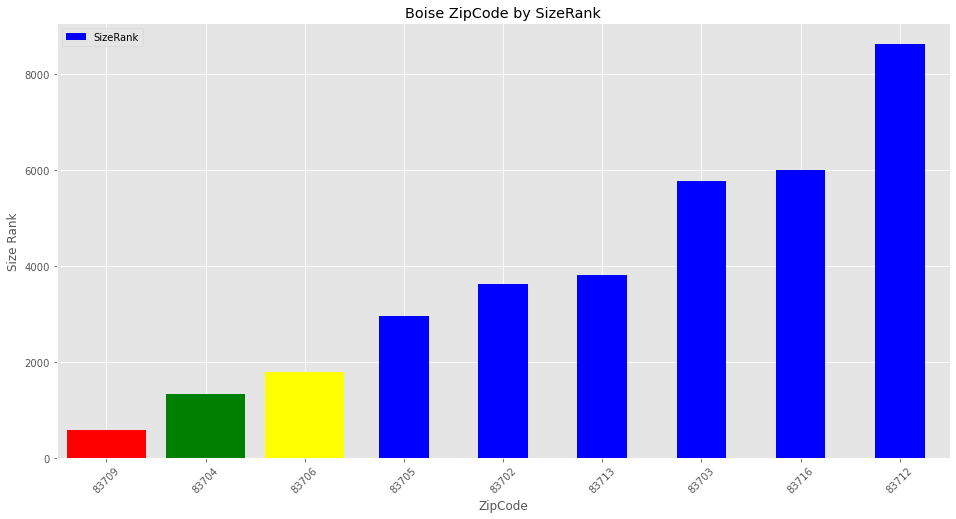

In [27]:
group_rnk.plot.bar(color='blue', figsize=(16,8))

# Assign different colors to first three bars
colors = ['red', 'green', 'yellow']
for i in range(3):
    plt.bar(i, group_rnk.iloc[i], color=colors[i])
    
plt.title('Boise ZipCode by SizeRank')
plt.ylabel('Size Rank')
plt.xticks(rotation=45)
plt.show();

- Looking at the graph above, the smaller the number, the higher the rank. I put the top three ZipCodes in different colors to stand out from the rest. 

### ZipCodes grouped by mean value

In [28]:
group_val = boise.groupby('ZipCode').agg({'value': 'mean'})
group_val

,value
ZipCode,
83702,319838.157895
83703,190135.526316
83704,164397.368421
83705,154701.315789
83706,200582.894737
83709,197040.789474
83712,333967.105263
83713,195805.263158
83716,252846.052632


In [29]:
group_val = group_val.sort_values('value', ascending=False)
group_val

,value
ZipCode,
83712,333967.105263
83702,319838.157895
83716,252846.052632
83706,200582.894737
83709,197040.789474
83713,195805.263158
83703,190135.526316
83704,164397.368421
83705,154701.315789


- This is a list of Boise ZipCodes and the mean value of the homes in descending order. 83709, 83704, and 83706 were the top three highest ranked zipcodes in terms of SizeRank. However in terms of mean value, they did not land in the top 3. The top three ZipCodes in terms of mean value were **83712**, **83702**, **83716**.

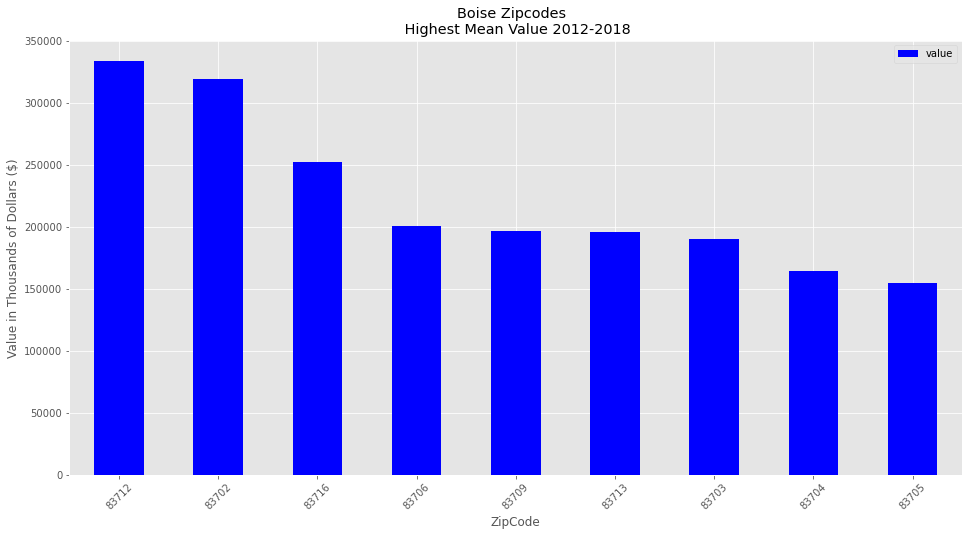

In [30]:
group_val.plot.bar(color='blue', figsize=(16,8))

plt.title('Boise Zipcodes  \n Highest Mean Value 2012-2018')
plt.ylabel('Value in Thousands of Dollars ($)')
plt.xticks(rotation=45)
plt.show();




### Drop SizeRank column
 - SizeRank will not have any influence in my findings, therefore it will be dropped from the dataset. 

In [31]:
boise.drop(columns=['SizeRank'], inplace=True)

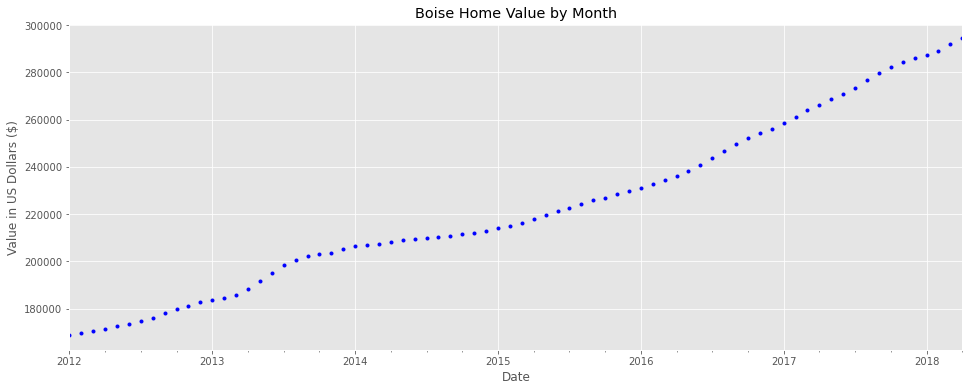

<Figure size 432x288 with 0 Axes>

In [32]:
monthly_data = boise.resample('MS').mean()['value']
monthly_data.plot(figsize=(16,6), style='.b')
plt.title('Boise Home Value by Month')
plt.ylabel('Value in US Dollars ($)')
plt.show();

plt.savefig('boise_home_value_monthly')

- From 2012 there has been an increase in home value every year. Several factors can lead to this:
    - Homes in Boise are affordable compared to homes in more densly populated areas.
    - The law of supply and demand. More and more of the population is moving to Idaho driving the cost of homes         up.
    - With more of the population relocating to Boise, it drives the price up. 

### Closer look at Boise ZipCodes
- Let's take a deeper look into the top 5 zipcodes in terms of mean value.
- I will list them in order from largest mean value of homes to the lowest mean value homes. 

In [33]:
group_val

,value
ZipCode,
83712,333967.105263
83702,319838.157895
83716,252846.052632
83706,200582.894737
83709,197040.789474
83713,195805.263158
83703,190135.526316
83704,164397.368421
83705,154701.315789


### 83712

In [34]:
boise.loc[boise['ZipCode'] == 83712]

,ZipCode,City,State,CountyName,value
Date,,,,,
2012-01-01,83712,Boise,ID,Ada,254500.0
2012-02-01,83712,Boise,ID,Ada,255900.0
2012-03-01,83712,Boise,ID,Ada,257200.0
2012-04-01,83712,Boise,ID,Ada,258800.0
2012-05-01,83712,Boise,ID,Ada,261000.0
...,...,...,...,...,...
2017-12-01,83712,Boise,ID,Ada,417900.0
2018-01-01,83712,Boise,ID,Ada,424400.0
2018-02-01,83712,Boise,ID,Ada,428900.0


- The mean value of a home located in this ZipCode was **254,500** dollars in 2012. 
- Six year later in 2018, the mean value of a home in this ZipCode grew to **433,500** dollars.

### 83702

In [35]:
boise.loc[boise['ZipCode'] == 83702]

,ZipCode,City,State,CountyName,value
Date,,,,,
2012-01-01,83702,Boise,ID,Ada,244200.0
2012-02-01,83702,Boise,ID,Ada,245800.0
2012-03-01,83702,Boise,ID,Ada,247800.0
2012-04-01,83702,Boise,ID,Ada,249200.0
2012-05-01,83702,Boise,ID,Ada,250800.0
...,...,...,...,...,...
2017-12-01,83702,Boise,ID,Ada,416600.0
2018-01-01,83702,Boise,ID,Ada,423600.0
2018-02-01,83702,Boise,ID,Ada,429300.0


- The mean value of a home located in this ZipCode was **244,200** dollars in 2012. 
- Six year later in 2018, the mean value of a home in this ZipCode grew to **441,000** dollars.

### 83716

In [36]:
boise.loc[boise['ZipCode'] == 83716]

,ZipCode,City,State,CountyName,value
Date,,,,,
2012-01-01,83716,Boise,ID,Ada,200900.0
2012-02-01,83716,Boise,ID,Ada,201900.0
2012-03-01,83716,Boise,ID,Ada,203000.0
2012-04-01,83716,Boise,ID,Ada,204100.0
2012-05-01,83716,Boise,ID,Ada,205500.0
...,...,...,...,...,...
2017-12-01,83716,Boise,ID,Ada,299300.0
2018-01-01,83716,Boise,ID,Ada,299000.0
2018-02-01,83716,Boise,ID,Ada,300000.0


- The mean value of a home located in this ZipCode was **200,900** dollars in 2012. 
- Six year later in 2018, the mean value of a home in this ZipCode grew to **305,600** dollars.

### 83706

In [37]:
boise.loc[boise['ZipCode'] == 83706]

,ZipCode,City,State,CountyName,value
Date,,,,,
2012-01-01,83706,Boise,ID,Ada,156600.0
2012-02-01,83706,Boise,ID,Ada,156900.0
2012-03-01,83706,Boise,ID,Ada,157000.0
2012-04-01,83706,Boise,ID,Ada,156900.0
2012-05-01,83706,Boise,ID,Ada,156700.0
...,...,...,...,...,...
2017-12-01,83706,Boise,ID,Ada,262500.0
2018-01-01,83706,Boise,ID,Ada,262300.0
2018-02-01,83706,Boise,ID,Ada,263300.0


- The mean value of a home located in this ZipCode was **156,600** dollars in 2012. 
- Six year later in 2018, the mean value of a home in this ZipCode grew to **267,500** dollars.

### 83709

In [38]:
boise.loc[boise['ZipCode'] == 83709]

,ZipCode,City,State,CountyName,value
Date,,,,,
2012-01-01,83709,Boise,ID,Ada,146100.0
2012-02-01,83709,Boise,ID,Ada,146400.0
2012-03-01,83709,Boise,ID,Ada,147000.0
2012-04-01,83709,Boise,ID,Ada,147800.0
2012-05-01,83709,Boise,ID,Ada,148900.0
...,...,...,...,...,...
2017-12-01,83709,Boise,ID,Ada,257000.0
2018-01-01,83709,Boise,ID,Ada,255200.0
2018-02-01,83709,Boise,ID,Ada,255100.0


- The mean value of a home located in this ZipCode was **146,100** dollars in 2012. 
- Six year later in 2018, the mean value of a home in this ZipCode grew to **256,600** dollars. 

# Sarima Modeling:

### Helper Functions: 
- I have created some functions to help with the modeling process. 

In [39]:
## Finding the best Sarimax
def find_best_SARIMAX(data, pdq, pdqs):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
            except:
                continue
    return ans

## Fit sarimax model
def fit_SARIMAX_model(data, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(data, 
                                      order=order, 
                                      seasonal_order=seasonal_order, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    output = model.fit()
    output.plot_diagnostics(figsize=(15, 18))
    return output

## ACF and PACF funtions
# acf and pacf function

def plot_acf_pacf(ts, figsize=(12,10), lags = 24, zipcode = 'add'):
    '''Plots the ACF and PACF of the time series.'''
    fig,ax = plt.subplots(nrows=3,
                         figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax




### Drop irrelevant columns for the modeling process

In [40]:
boise.drop(columns=['City', 'State', 'CountyName'], inplace=True)

In [41]:
boise.head()

,ZipCode,value
Date,,
2012-01-01,83709,146100.0
2012-01-01,83704,123800.0
2012-01-01,83706,156600.0
2012-01-01,83705,111100.0
2012-01-01,83702,244200.0


- For the modeling process, city, state, and CountyName carry no weight and are not necessary for the dataset. 

### Grouping Boise values by ZipCode

In [42]:
boise_grouped = boise.groupby(['ZipCode'], as_index = True).resample('MS').sum()
boise_grouped.head()

ZipCode     value
ZipCode Date                         
83702   2012-01-01    83702  244200.0
        2012-02-01    83702  245800.0
        2012-03-01    83702  247800.0
        2012-04-01    83702  249200.0
        2012-05-01    83702  250800.0

### Drop ZipCode column

In [43]:
boise_grouped.drop(columns=['ZipCode'], inplace=True)
boise_grouped.head()

value
ZipCode Date                
83702   2012-01-01  244200.0
        2012-02-01  245800.0
        2012-03-01  247800.0
        2012-04-01  249200.0
        2012-05-01  250800.0

- Now the dataframe is formatted appropriately for modeling. 

## 83709

In [44]:
seven_zero_nine = boise_grouped.loc[83709]
seven_zero_nine.head()

,value
Date,
2012-01-01,146100.0
2012-02-01,146400.0
2012-03-01,147000.0
2012-04-01,147800.0
2012-05-01,148900.0


### Find the cut off to determine 80/20 split for the training and test data

In [45]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_nine.shape[0]*0.8)
cutoff

61

- at index 61 is where we will begin the test set. From 0 through 60 will be the considered training data

In [46]:
seven_zero_nine[61:]

,value
Date,
2017-02-01,225600.0
2017-03-01,228500.0
2017-04-01,231900.0
2017-05-01,235200.0
2017-06-01,237000.0
2017-07-01,242200.0
2017-08-01,251800.0
2017-09-01,261200.0
2017-10-01,263500.0


- Our training data will be from 2012-01-01 and end and 2017-01-01. The test data begins at 2017-02-01 and ends at 2018-04-01.

### Create train/test variables

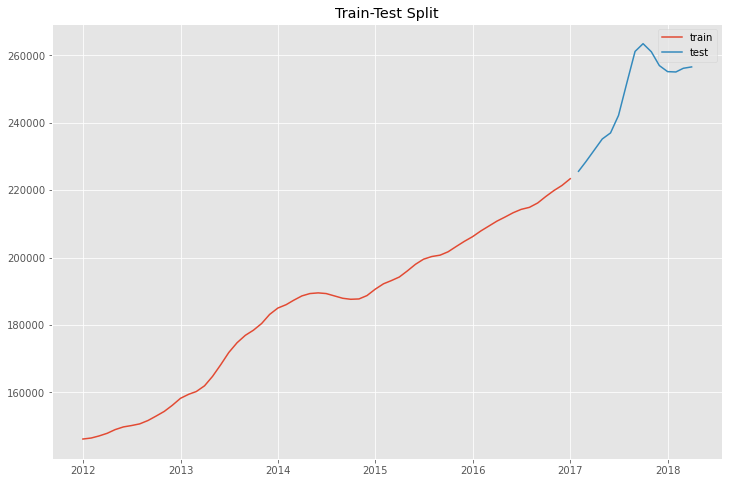

In [47]:
train = seven_zero_nine[:cutoff]

test = seven_zero_nine[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

- Looking at this graph, there is a steady increase from 2012 till early 2013 with a slightly faster rate of increase from early 2013 to about mid 2014, then decreases slightly before leveling off and steadily increasing again by late 2014.
- From mid 2014 to 2017 the mean value consistently increases at a steady rate.
- 2017 shows the fastest rate of increase in home values spiking in late 2017. After the spike in late 2017 there was a steep decrease, but by 2018 the value of home began to steadily increase once again.

### ACF and PACF

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

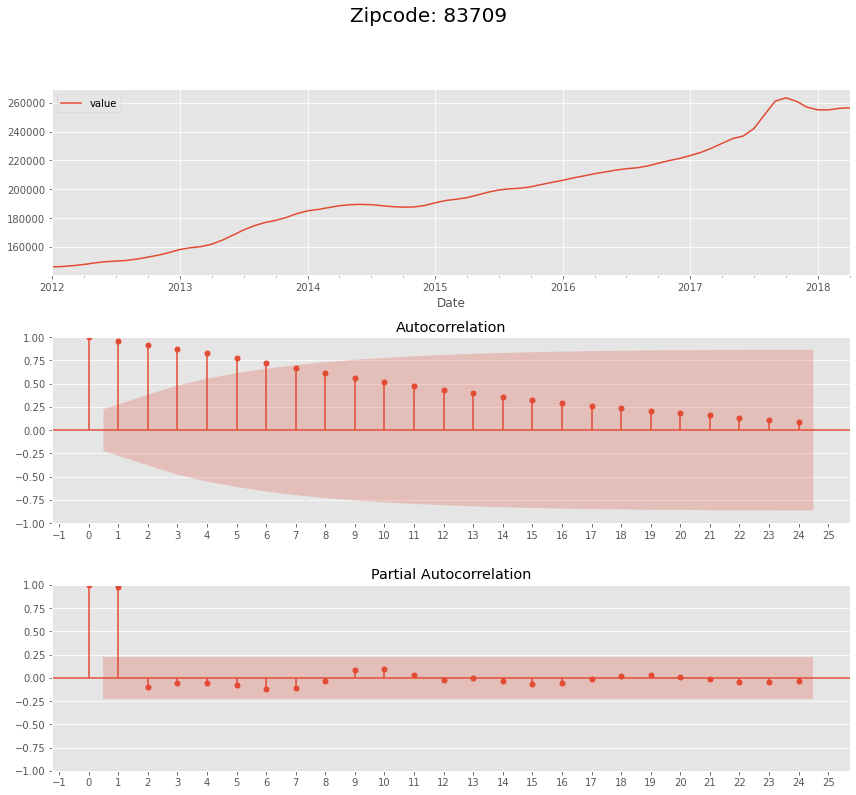

In [48]:
plot_acf_pacf(seven_zero_nine, zipcode= '83709')
plt.show()

### Parameter selection for the ARIMA time series model

- **Number of AR (Auto-Regressive) terms (p)**
    - p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
    
- **Number of Differences (d)**
    - d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation.
    
- **Number of MA (Moving Average) terms (q)**
    - q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past.

In [49]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

- The first step towards fitting an ARIMA model is to find the values of ARIMA(p,d,q)(P,D,Q)s that produce the desired output.

### AIC (Akaike Information Criterion) as Regularization Measure
- we are interested in finding the model that yields the lowest AIC value.

In [50]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1628.6554715891596
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=276321.00350357394
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1074.7608067932592
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=800.9896953931972
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1015.3058393458962
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=1039.164538655018
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=795.0130995893325
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=761.2725664089535
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=23782.178214837102
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=254534.87908446955
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1027.846007475738
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=762.0917158645034
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1286.4535423892971
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1236.1569881197602
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=800.1584136836245
AR

In [51]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           539.219
Name: 54, dtype: object

The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `539.219`. We should therefore consider this to be optimal option out of all the models we have considered.

### Fitting the time series model - ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -440.323
Date:                            Mon, 13 Feb 2023   AIC                            886.646
Time:                                    09:34:57   BIC                            892.382
Sample:                                01-01-2012   HQIC                           888.830
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7469      0.047     15.954      0.000       0.655       0.839
ar.S.L12      -0.4713      0.584     -0.807      0.420      -1.615       0.673
sigma2      2.302e+06   2.23e+05     10.306      0.000    1.86e+06    2.74e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.85   Jarque-Bera (JB):                71.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.58   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

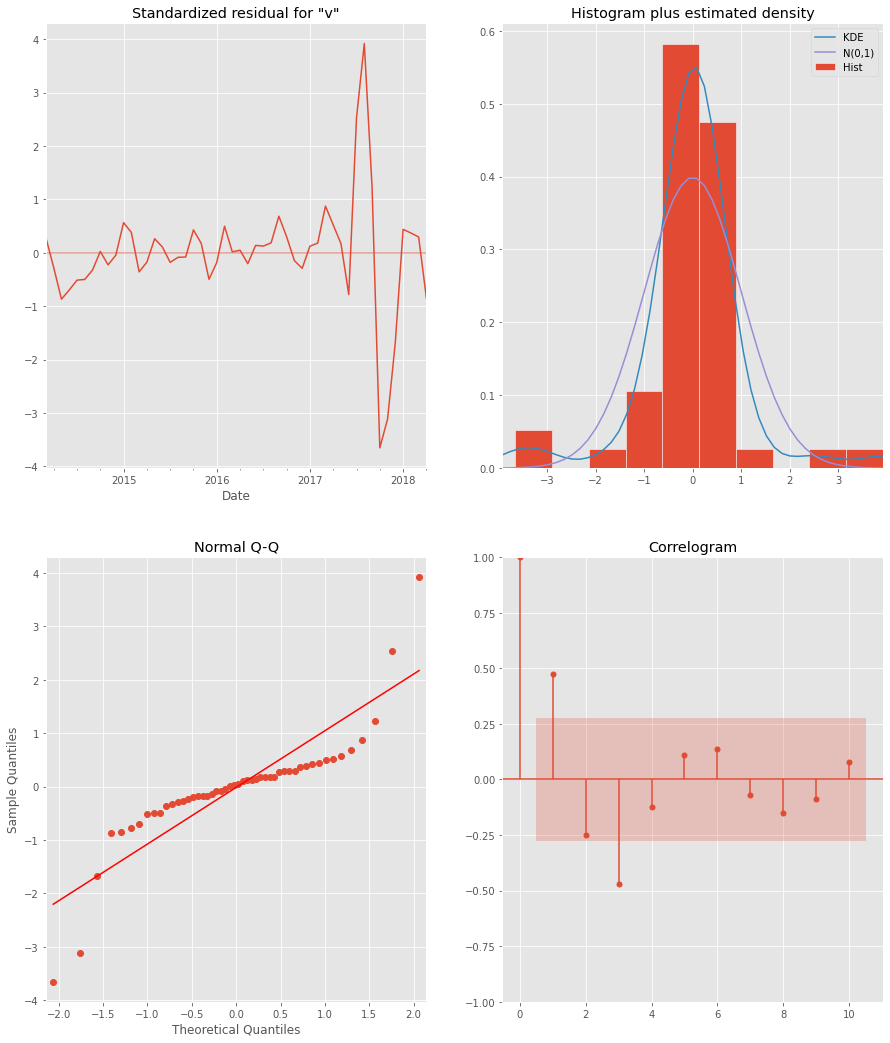

In [52]:
output = fit_SARIMAX_model(seven_zero_nine, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: There appears to be some seasonality till about mid 2017 where there appears to be some random noise. 
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares slightly away from the line. 
- **Correlogram**: There are two spikes outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

- In the cell below: 
    - Get the predictions from 1st february 2017 till 2018 (end of time series)

    - Get the confidence intervals for all predictions

    - For get_predictions(), set the dynamic parameter to False to ensure that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point

In [53]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

- We shall now plot the real and forecasted values of the time series to assess how well we did:

    -Plot the observed values from the dataset, starting at 2012
    -Use .predicted_mean.plot() method to plot predictions
    -Plot the confidence intervals overlapping the predicted values

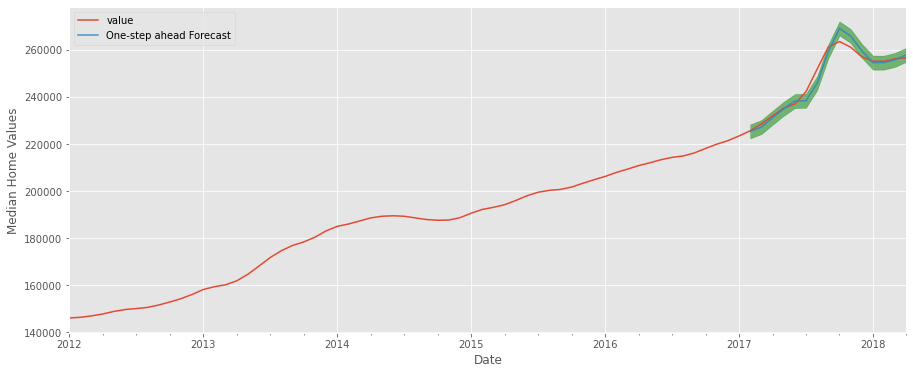

In [54]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_nine['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- For the most part, the forecasts align with the true values as seen above, with an overall increase trend. 

### Accuracy of our forecast with Root Mean Squared Error

In [55]:
# Get the real and predicted values
seven_zero_nine_forecasted = pred.predicted_mean
seven_zero_nine_truth = seven_zero_nine.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_nine_forecasted - seven_zero_nine_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 2083.69


- The RMSE of 2083.69 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 2083.69 dollars from the actual values. 

- This model also had an AIC of 539.219

### Dynamic Forecasting

- We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.


In [56]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

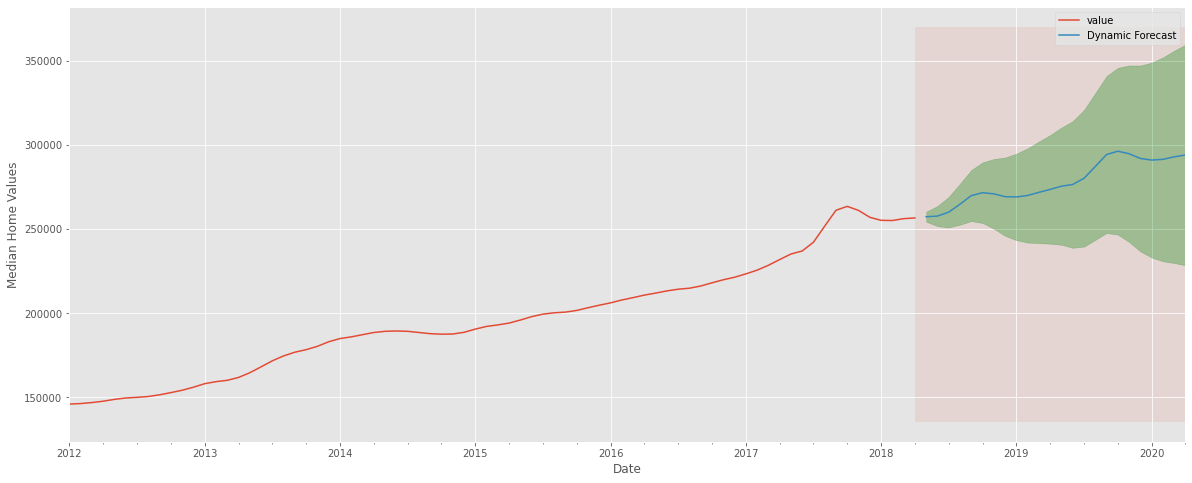

In [57]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_nine['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_nine_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Looking at the image above, it appears that the value of homes in boise, ID will continue to increase. With two slight spikes in value.

### Producing and visualizing forecasts

In [58]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,254364.521911,260312.443102,257338.482507
2018-06-01,251742.710158,263714.993448,257728.851803
2018-07-01,250972.636202,269172.886769,260072.761485
2018-08-01,252598.332322,276954.895535,264776.613929
2018-09-01,254716.358742,285024.362467,269870.360604


- The output of this code can now be used to plot the time series and forecasts of its future values. 

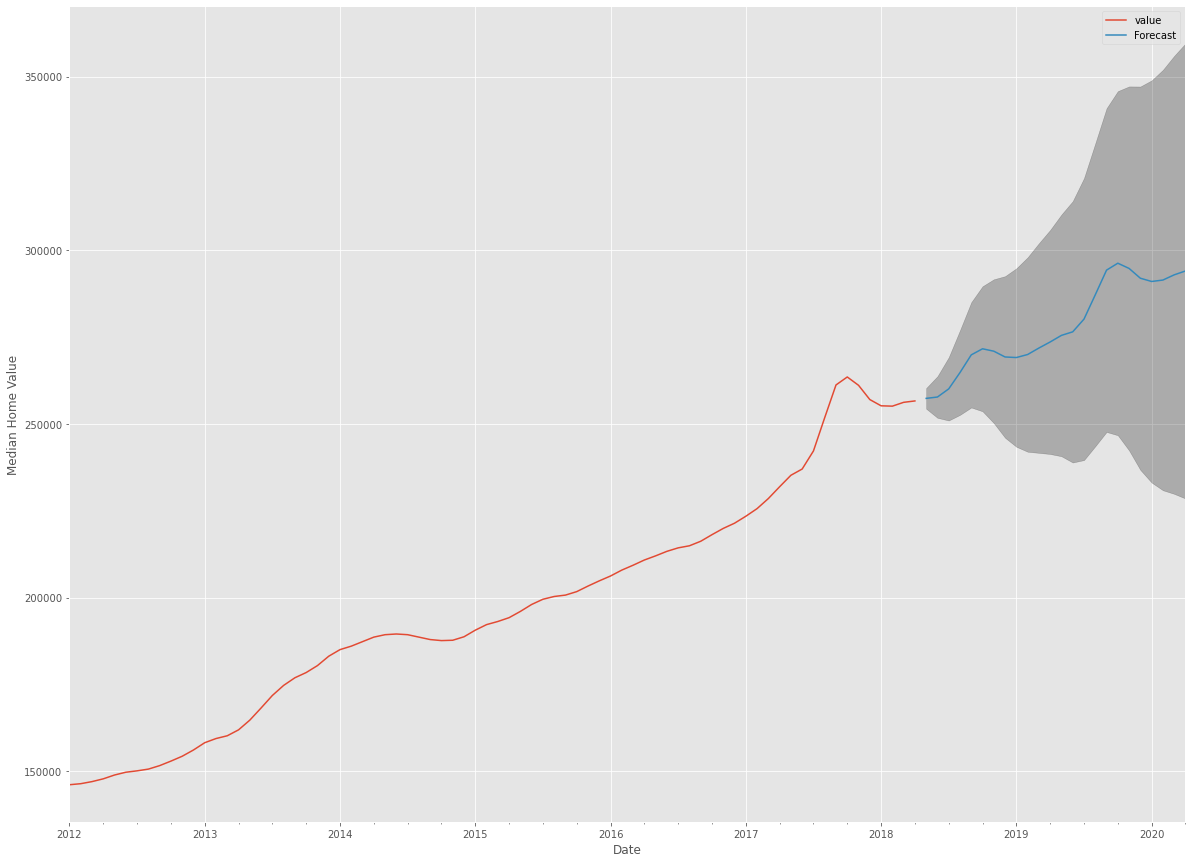

In [59]:
# Plot future predictions with confidence intervals
ax = seven_zero_nine.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

## Average Return on Investment (ROI)
- The first predicted mean value represents the cost of the home in the beginning of the real estate investment. The ROI is calculated by subtracting the cost from the averaged predicted values, then dividing that value by the cost. This is a 2 year ROI.

In [60]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-1.155661,1.155661,0.000000
2018-06-01,-2.174479,2.477869,0.151695
2018-07-01,-2.473725,4.598770,1.062522
2018-08-01,-1.841990,7.622806,2.890408
2018-09-01,-1.018940,10.758546,4.869803
2018-10-01,-1.445465,12.542187,5.548361
2018-11-01,-2.765034,13.322710,5.278838
2018-12-01,-4.407287,13.671126,4.631920
2019-01-01,-5.413099,14.551467,4.569184
2019-02-01,-5.969221,15.783902,4.907341


## Results: 

In [61]:
data = {'Zipcode':  ['83709', '83704', '83706', '83705', '83702', '83713', '83703', '83716', '83712']}
    
results = pd.DataFrame(data, columns = ['Zipcode'])
results['Two_YR_ROI_Percentage'] = 1
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,1
1,83704,1
2,83706,1
3,83705,1
4,83702,1


In [62]:
results.Two_YR_ROI_Percentage[0] = roi['mean'][-1]
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,1
2,83706,1
3,83705,1
4,83702,1


- For area code 83709, the forecasted 2 year ROI is 14%.  

## 83704

In [63]:
seven_zero_four = boise_grouped.loc[83704]

In [64]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_four.shape[0]*0.8)
cutoff

61

In [65]:
# Test Data
seven_zero_four[61:]

,value
Date,
2017-02-01,192900.0
2017-03-01,194100.0
2017-04-01,195500.0
2017-05-01,197200.0
2017-06-01,199200.0
2017-07-01,199000.0
2017-08-01,196400.0
2017-09-01,196700.0
2017-10-01,200900.0


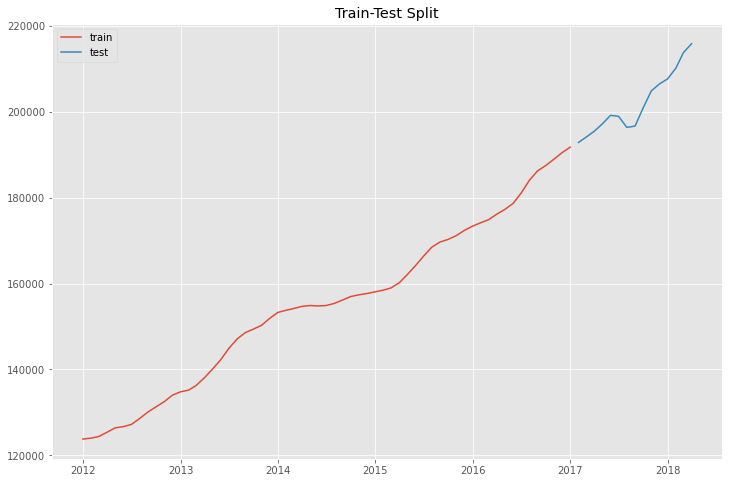

In [66]:

train = seven_zero_four[:cutoff]

test = seven_zero_four[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

In [67]:
seven_zero_four = boise_grouped.loc[83704]
seven_zero_four.tail()

,value
Date,
2017-12-01,206500.0
2018-01-01,207700.0
2018-02-01,210200.0
2018-03-01,213800.0
2018-04-01,215900.0


## ACF & PACF

- The time series trends positively. In about mid 2017 there is short decrease in value for a couple of months, then begins to even out before continuing to increase positively. 
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

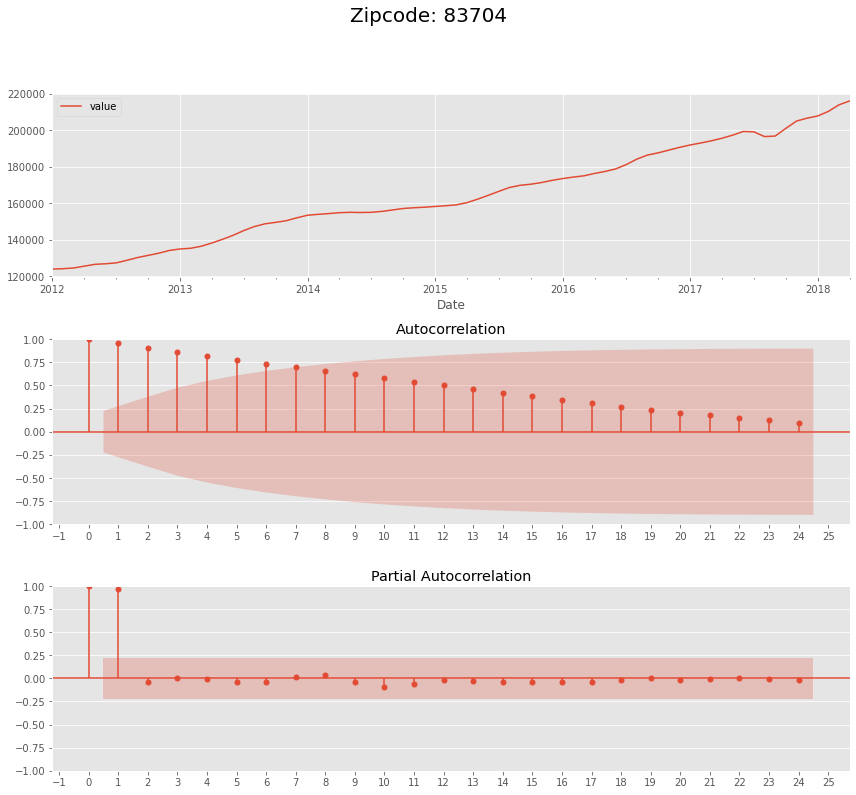

In [68]:
plot_acf_pacf(seven_zero_four, zipcode= '83704')
plt.show()

### Parameter selection for the ARIMA time series model

In [69]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [70]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1607.8068912305614
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=201216.94563344726
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1055.7336468410306
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=790.286002275818
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=969.3897307762956
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=942.8285520625384
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=772.0238291440097
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=748.657893502281
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=1541.674790879383
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=184194.45359179587
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1044.306385389932
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=731.6803447451764
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1269.3783030610316
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1288.9348190471153
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=791.8922385598272
ARIMA 

In [71]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           525.529
Name: 54, dtype: object

The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `525.529`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -418.896
Date:                            Mon, 13 Feb 2023   AIC                            843.792
Time:                                    09:35:12   BIC                            849.528
Sample:                                01-01-2012   HQIC                           845.976
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6002      0.090      6.637      0.000       0.423       0.778
ar.S.L12      -0.7801      0.398     -1.961      0.050      -1.560      -0.001
sigma2      1.147e+06   1.42e+05      8.072      0.000    8.68e+05    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.73   Jarque-Bera (JB):                58.37
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              16.92   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

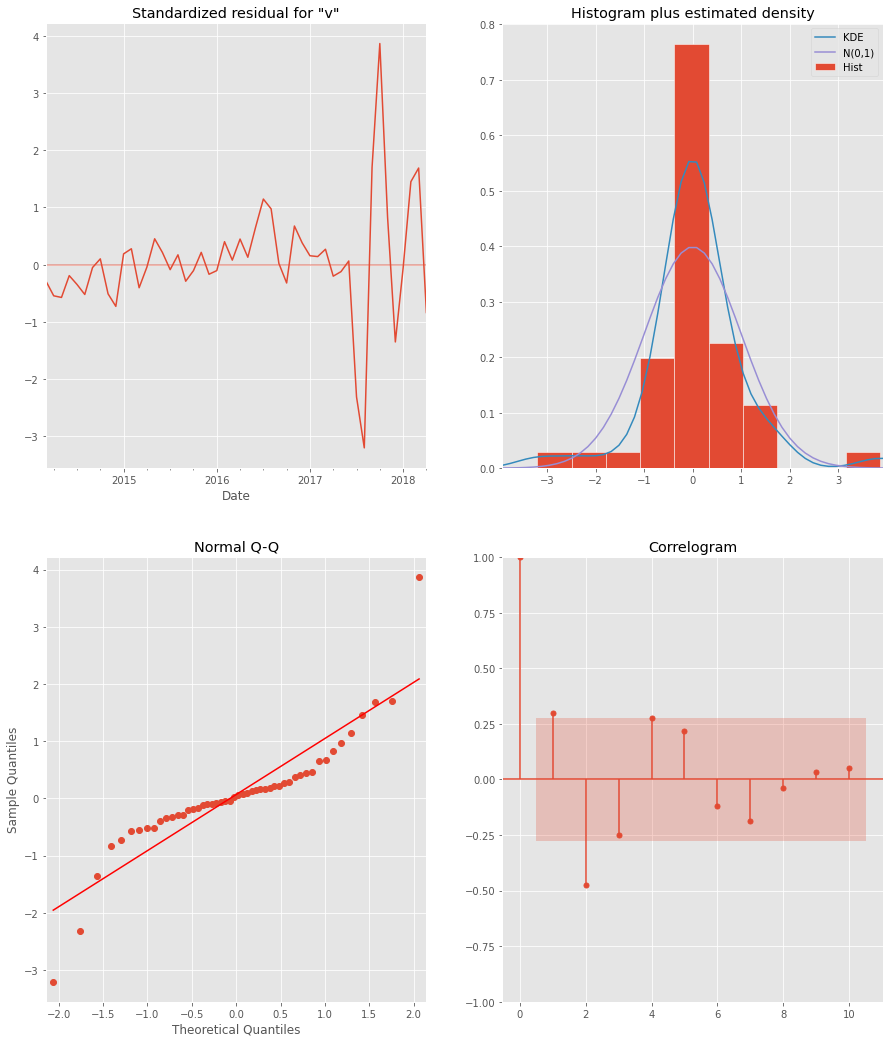

In [72]:
output = fit_SARIMAX_model(seven_zero_four, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: There appears to be some seasonality till about mid 2017 where there appears to be some random noise. 
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares slightly away from the line. 
- **Correlogram**: There are two spikes outside of the shaded area. This means there could be some missed seasonality component.

- For our time series model, we see that each weight has a **p-value** lower or close to 0.05, so its reasonable to retain all of them in our model. 

### Validating the model: One-step ahead forecasting

In [73]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

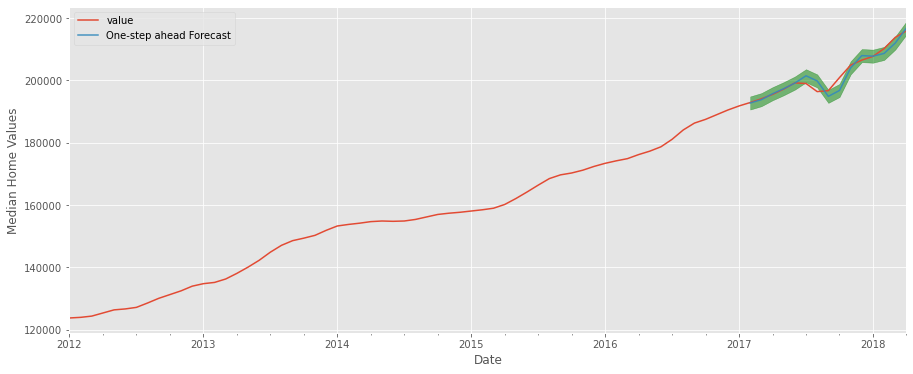

In [74]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_four['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecasts align with the true values as seen above, with an overall increase trend. 

### Accuracy of our forecast with Root Mean Squared Error

In [75]:
# Get the real and predicted values
seven_zero_four_forecasted = pred.predicted_mean
seven_zero_four_truth = seven_zero_four.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_four_forecasted - seven_zero_four_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 1292.15


- The RMSE of 1292.15 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 1292.15 dollars from the actual values. 

- AIC = 525.529

### Dynamic Forecasting

In [76]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

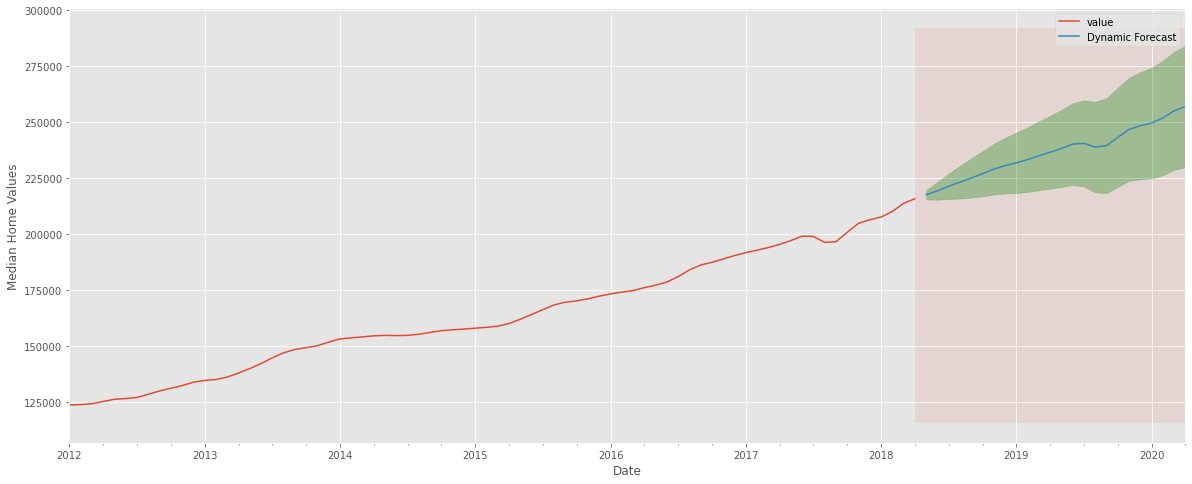

In [77]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_four['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_four_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- The dynamic forecast shows a positive trend into the future. 

### Producing and visualizing forecasts

In [78]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,215499.946345,219697.973857,217598.960101
2018-06-01,215450.392427,223372.081200,219411.236813
2018-07-01,215695.969161,227119.293309,221407.631235
2018-08-01,215962.556031,230591.298888,223276.927460
2018-09-01,216348.040131,233891.261392,225119.650762


- The output of this code can now be used to plot the time series and forecasts of its future values. 

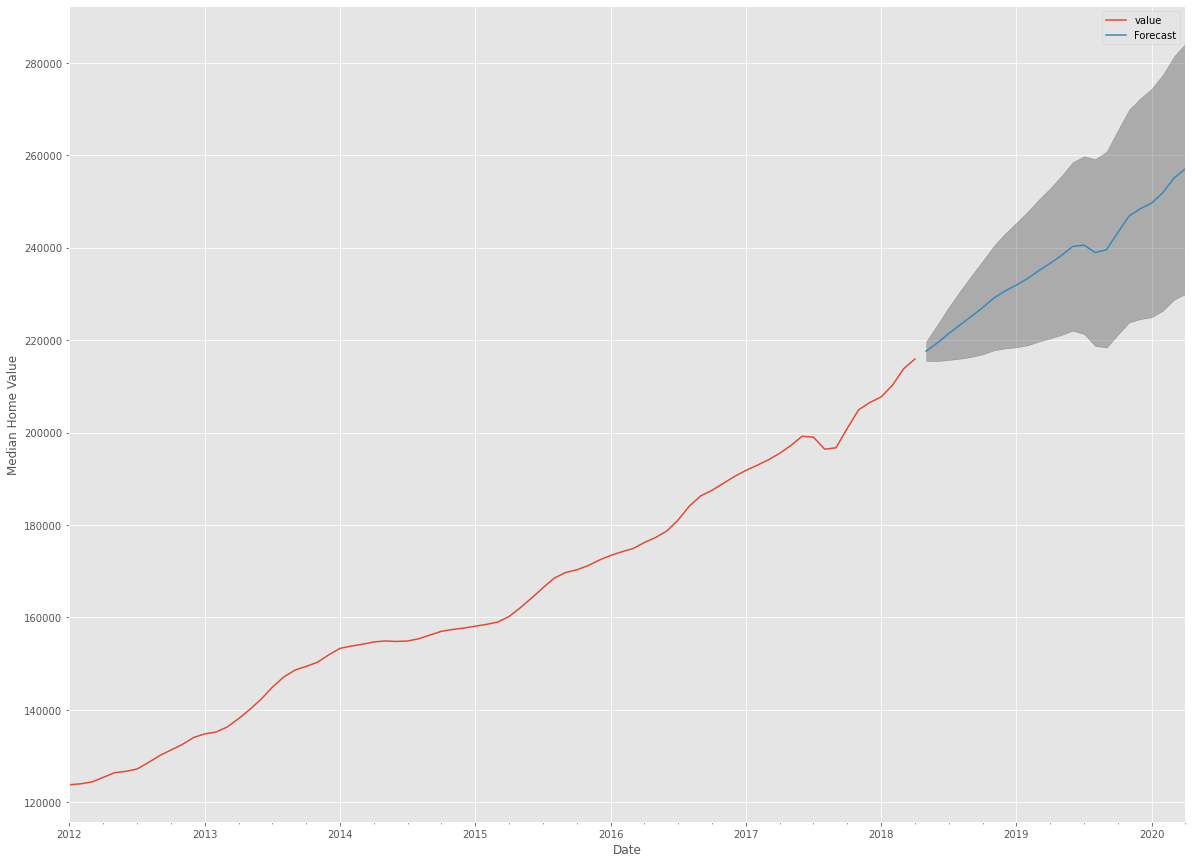

In [79]:
# Plot future predictions with confidence intervals
ax = seven_zero_four.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [80]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-0.964625,0.964625,0.000000
2018-06-01,-0.987398,2.653101,0.832852
2018-07-01,-0.874540,4.375174,1.750317
2018-08-01,-0.752028,5.970772,2.609372
2018-09-01,-0.574874,7.487307,3.456216
2018-10-01,-0.313526,8.968820,4.327647
2018-11-01,0.079639,10.479806,5.279722
2018-12-01,0.269516,11.700877,5.985197
2019-01-01,0.381417,12.770852,6.576134
2019-02-01,0.582535,13.868129,7.225332


## Results:

In [81]:
results.Two_YR_ROI_Percentage[1] = roi['mean'][-1]
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,1
3,83705,1
4,83702,1


## 83706

In [82]:
seven_zero_six = boise_grouped.loc[83706]
seven_zero_six.tail()

,value
Date,
2017-12-01,262500.0
2018-01-01,262300.0
2018-02-01,263300.0
2018-03-01,265700.0
2018-04-01,267500.0


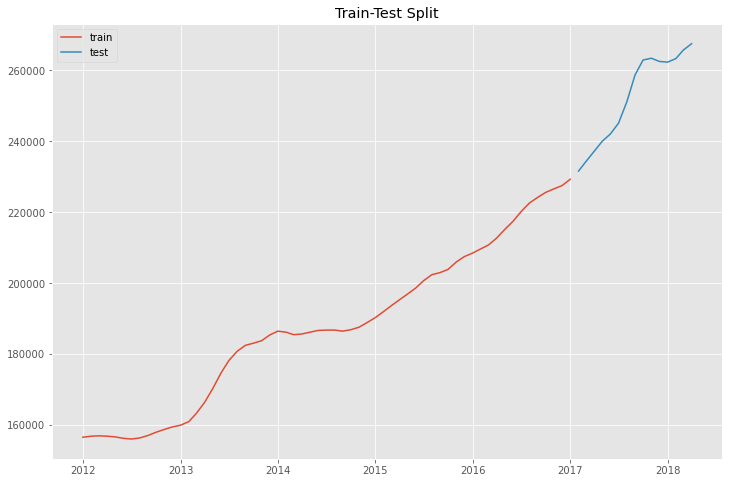

In [83]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_six.shape[0]*0.8)


train = seven_zero_six[:cutoff]

test = seven_zero_six[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

### AIC & PACF

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

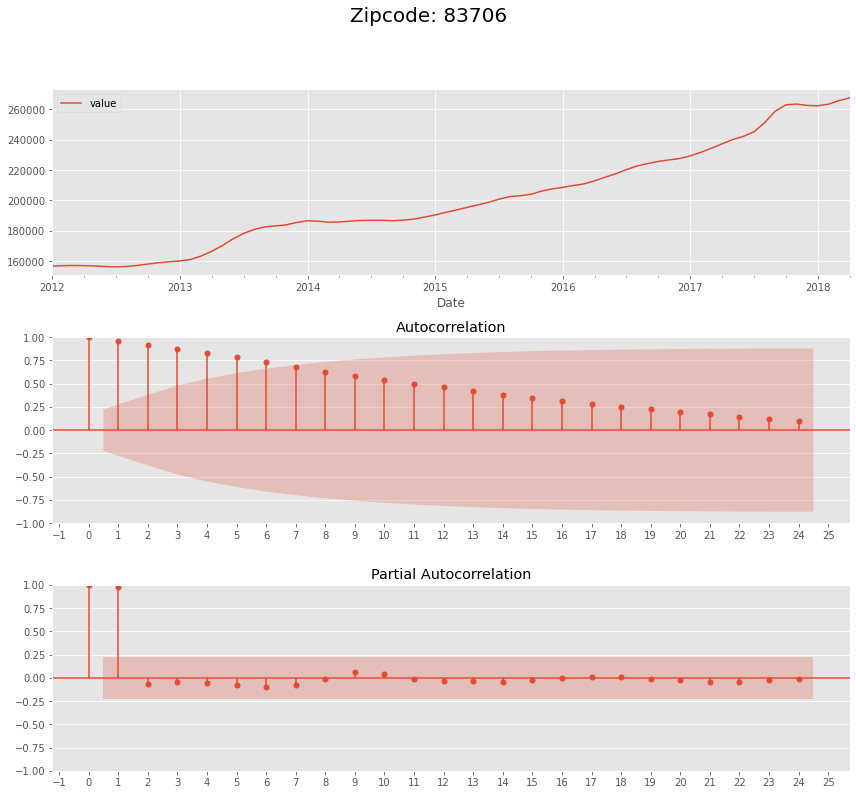

In [84]:
plot_acf_pacf(seven_zero_six, zipcode= '83706')
plt.show()

### Parameter selection for the ARIMA time series model


In [85]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [86]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1630.600370690789
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=299778.7119828826
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1074.319386740556
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=802.7936429817904
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1015.1359610457447
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=1044.5326279235276
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=805.4105282911407
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=782.2271278487251
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=26984.317663229787
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=305650.9822364844
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1017.1010262769502
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1170.6040240415607
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1287.8919971259484
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1237.5358546981583
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=802.0785741871218
ARI

In [87]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 0, 12)
aic           550.286
Name: 62, dtype: object

- The output of our code suggests that `ARIMA (1, 1, 1) x (1, 1, 0, 12)` yields the lowest AIC value of `550.286`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -409.431
Date:                             Mon, 13 Feb 2023   AIC                            826.862
Time:                                     09:35:24   BIC                            834.510
Sample:                                 01-01-2012   HQIC                           829.774
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6709      0.087      7.748      0.000       0.501       0.841
ma.L1          0.6866      0.142      4.846      0.000       0.409       0.964
ar.S.L12       0.0290      0.027      1.085      0.278      -0.023       0.082
sigma2      7.358e+05   1.41e+05      5.227      0.000     4.6e+05    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 4.34
Prob(Q):                              0.62   Prob(JB):                         0.11
Heteroskedasticity (H):               2.62   Skew:                             0.27
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

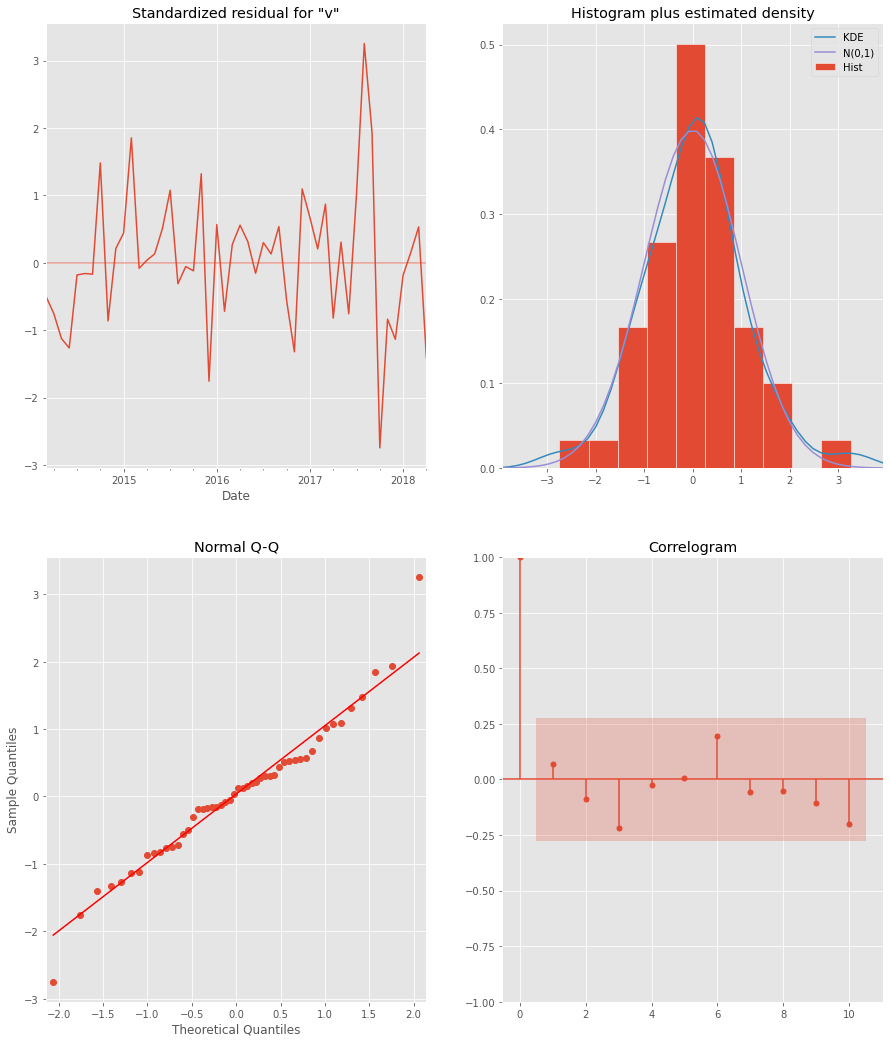

In [88]:
output = fit_SARIMAX_model(seven_zero_six, (1, 1, 1), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: Seems to show random noise without and distinct pattern. 
- **Histogram**: The histogram shows that the distribution appears to be to normaly distributed. 
- **QQ-plot**: QQ-plot flares slightly away from the line in a couple of areas but for the most part follows the line. 
- **Correlogram**: The points in the correlogram fall inside the box and do not indicate a missed seasonality component.

### Validating the model: One-step ahead forecasting

In [89]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

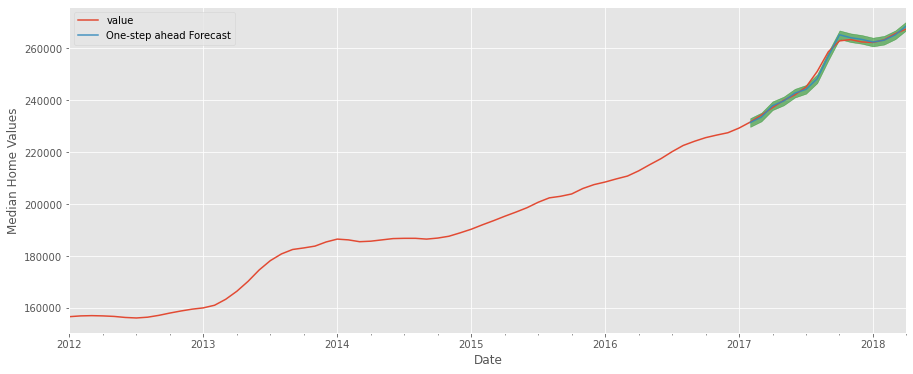

In [90]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_six['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecasts align with the true values as seen above, with overall increase trend.

### Accuracy of our forecast with Root Mean Squared Error

In [91]:
# Get the real and predicted values
seven_zero_six_forecasted = pred.predicted_mean
seven_zero_six_truth = seven_zero_six.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_six_forecasted - seven_zero_six_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 924.03


- The RMSE of 924.03 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 924.03 dollars from the actual values. 

### Dynamic Forecasting

In [92]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

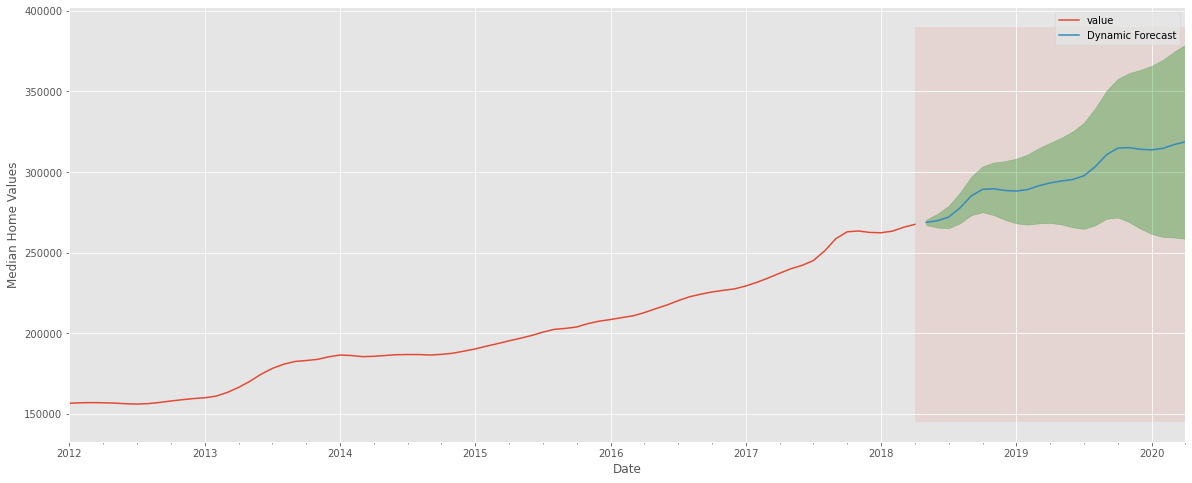

In [93]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_six['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_six_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- The dynamic forecast shows an increasing trend in home values. 

### Producing and visualizing forecasts

In [94]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,267046.698817,270409.114955,268727.906886
2018-06-01,265454.251462,274064.814728,269759.533095
2018-07-01,265074.858118,279035.817331,272055.337724
2018-08-01,268128.361334,287234.822867,277681.592100
2018-09-01,273165.512592,297104.400456,285134.956524


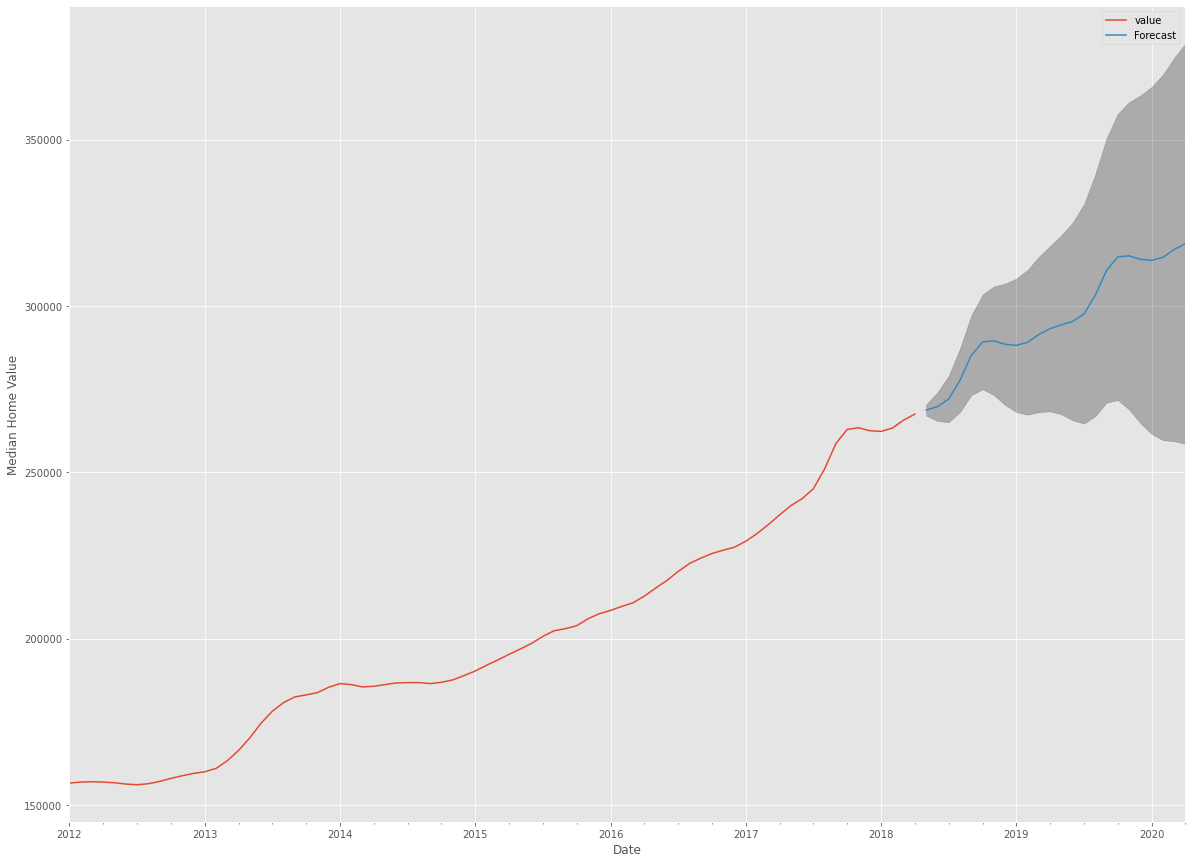

In [95]:
# Plot future predictions with confidence intervals
ax = seven_zero_six.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [96]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-0.625617,0.625617,0.000000
2018-06-01,-1.218204,1.985989,0.383892
2018-07-01,-1.359386,3.835817,1.238216
2018-08-01,-0.223105,6.886860,3.331878
2018-09-01,1.651338,10.559563,6.105451
2018-10-01,2.327615,12.909408,7.618512
2018-11-01,1.677395,13.813428,7.745412
2018-12-01,0.564219,14.145734,7.354977
2019-01-01,-0.230355,14.699824,7.234735
2019-02-01,-0.520230,15.673372,7.576571


## Results:

In [97]:
results.Two_YR_ROI_Percentage[2] = roi['mean'][-1]
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,1
4,83702,1


## 83705

In [98]:
seven_zero_five = boise_grouped.loc[83705]
seven_zero_five.tail()

,value
Date,
2017-12-01,208200.0
2018-01-01,207400.0
2018-02-01,208100.0
2018-03-01,210100.0
2018-04-01,211800.0


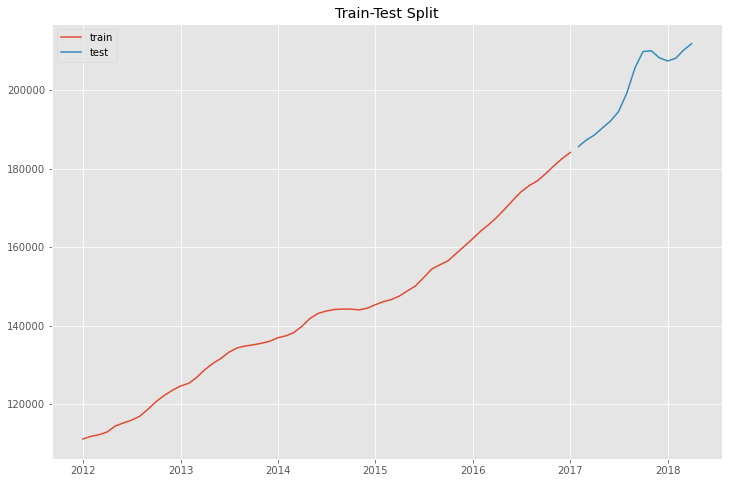

In [99]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_five.shape[0]*0.8)


train = seven_zero_five[:cutoff]

test = seven_zero_five[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

### ACF & PACF

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

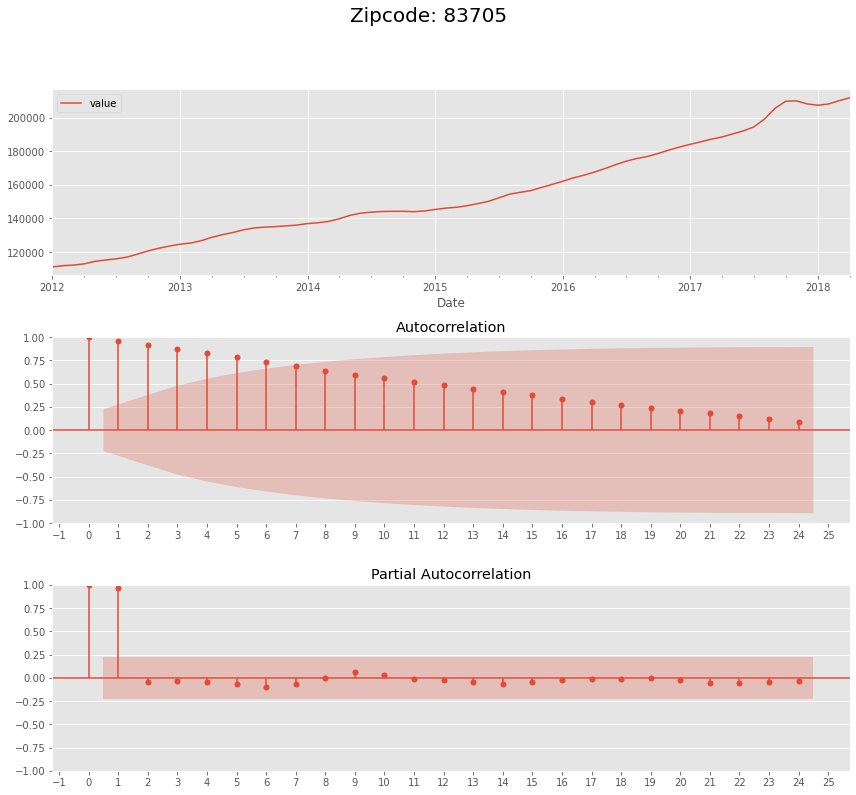

In [100]:
plot_acf_pacf(seven_zero_five, zipcode= '83705')
plt.show()

### Parameter selection for the ARIMA time series model

In [101]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [102]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1598.6711863510395
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=1259.8810035897745
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1061.5899381339345
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=798.6665275186123
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=967.237043989679
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=948.1033366151078
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=766.7850898512145
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=735.3933651281499
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=1532.718444392994
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=1281.0365609013172
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1048.3382864487999
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=752.5803288352085
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1261.9918225960093
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1212.7094372378833
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=762.6890665620614
ARIM

### Fitting the time series model - ARIMA

In [103]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           533.606
Name: 54, dtype: object

- The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `533.606`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -415.398
Date:                            Mon, 13 Feb 2023   AIC                            836.795
Time:                                    09:35:33   BIC                            842.531
Sample:                                01-01-2012   HQIC                           838.980
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6892      0.063     10.969      0.000       0.566       0.812
ar.S.L12      -0.3692      0.312     -1.183      0.237      -0.981       0.242
sigma2      9.632e+05   1.12e+05      8.565      0.000    7.43e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.50   Jarque-Bera (JB):                59.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.95   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

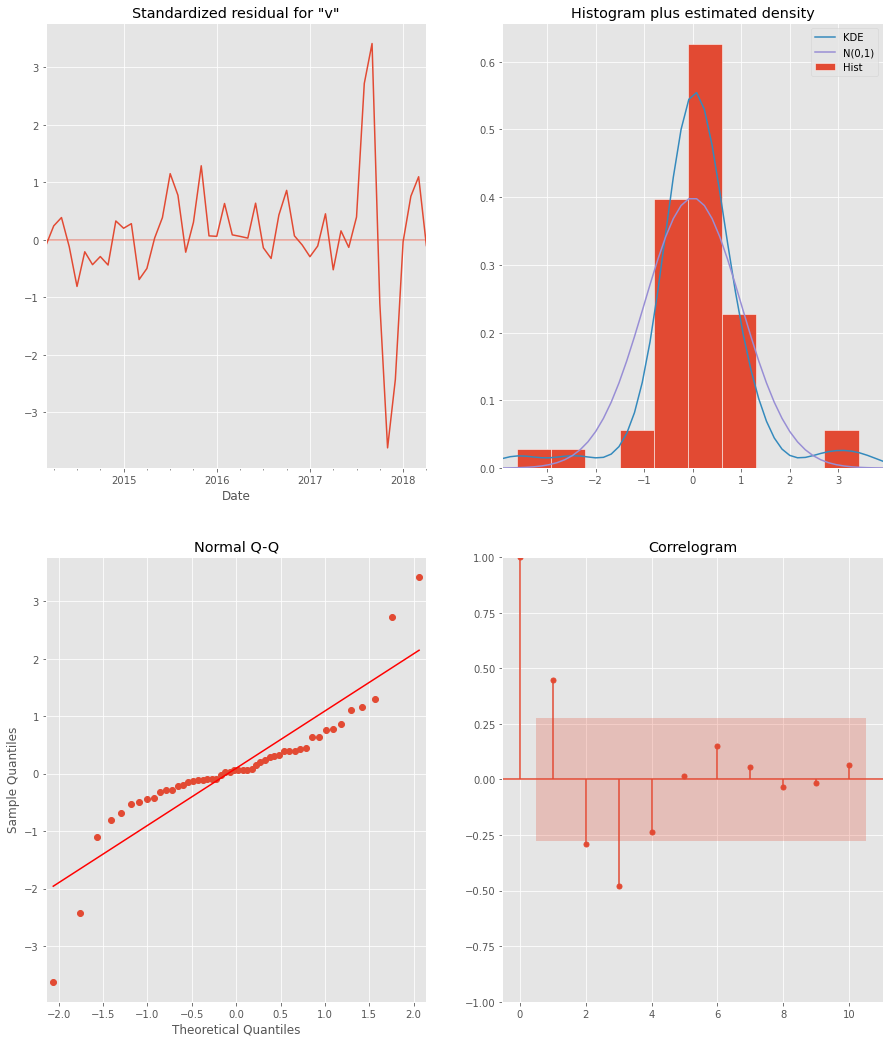

In [104]:
output = output = fit_SARIMAX_model(seven_zero_five, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: This looks pretty random for the most part. Maybe so a small amount of seasonlity. 
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares away from the line. 
- **Correlogram**: There are three spikes outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

In [105]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

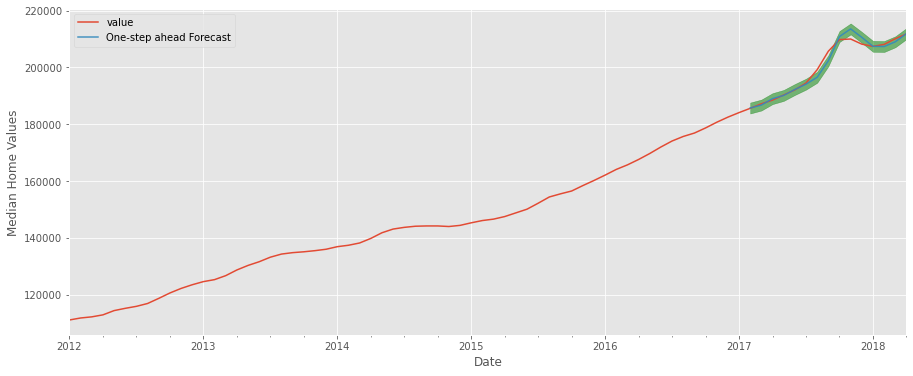

In [106]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_five['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecasted line for the most part follows the true values. It does however continue on a positive trend. 

### Accuracy of our forecast with Root Mean Squared Error

In [107]:
# Get the real and predicted values
seven_zero_five_forecasted = pred.predicted_mean
seven_zero_five_truth = seven_zero_five.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_five_forecasted - seven_zero_five_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 1115.22


- The RMSE of 1115.22 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 1115.22 dollars from the actual values. 

- AIC = 533.606

### Dynamic Forecasting

In [108]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

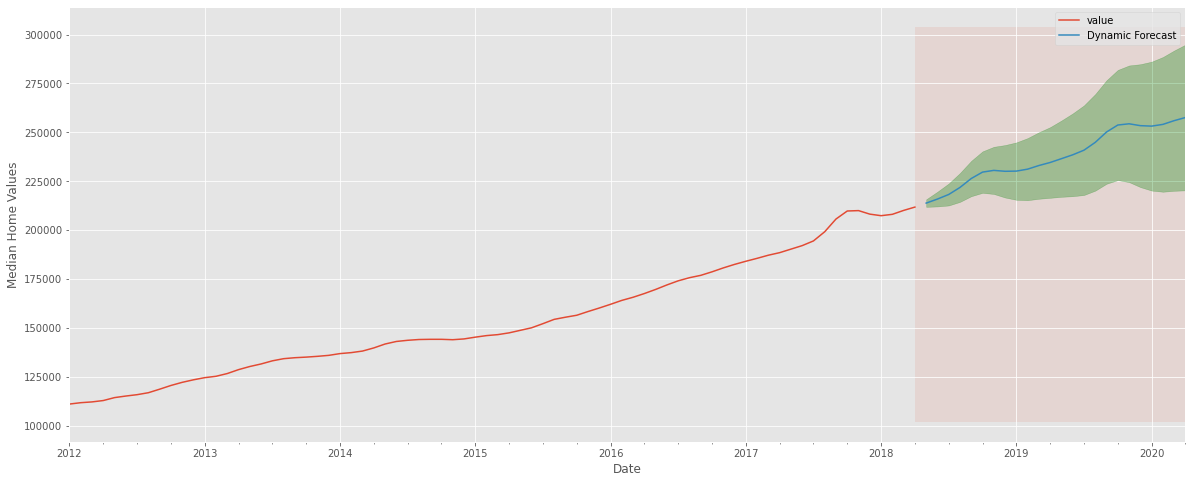

In [109]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_five['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_five_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

### Producing and visualizing forecasts

In [110]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,211910.167681,215757.347867,213833.757774
2018-06-01,212127.166794,219679.108589,215903.137692
2018-07-01,212630.490825,223871.060433,218250.775629
2018-08-01,214460.169873,229232.565868,221846.367871
2018-09-01,217368.804405,235465.406908,226417.105656


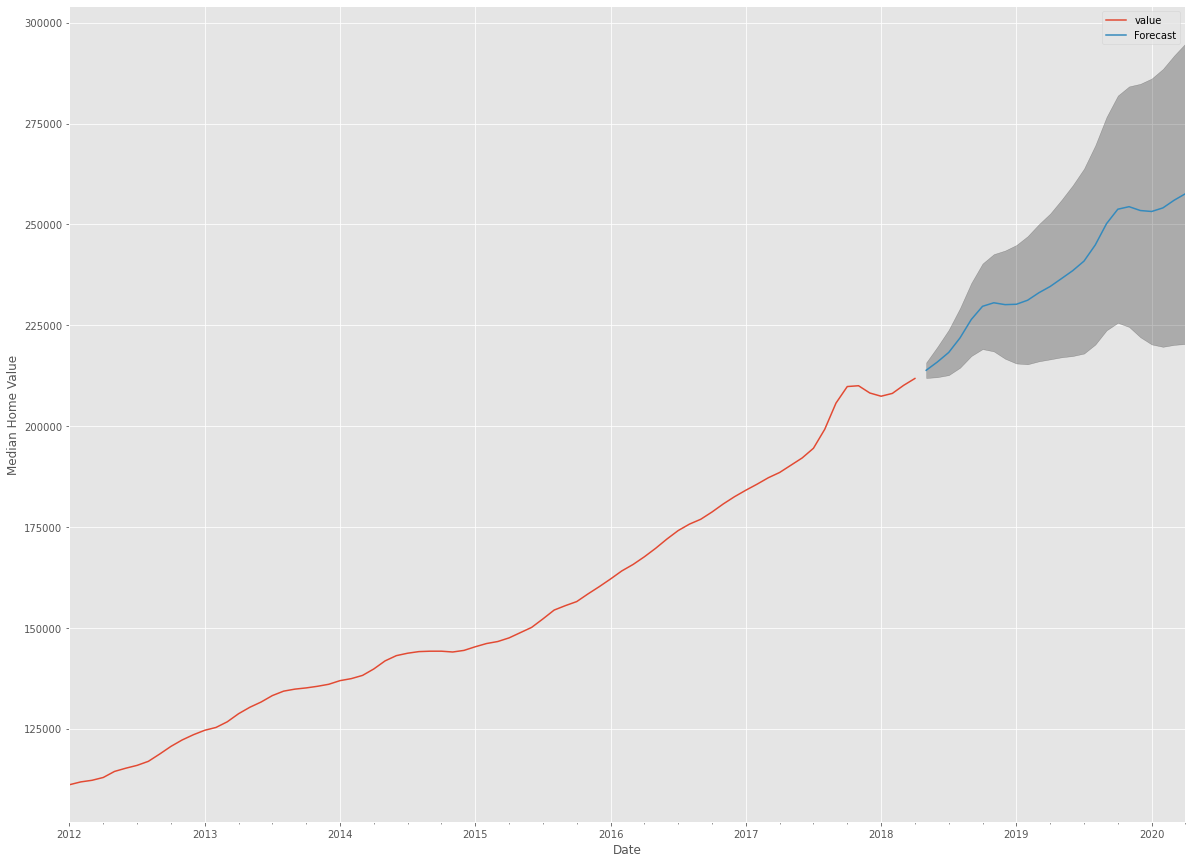

In [111]:
# Plot future predictions with confidence intervals
ax = seven_zero_five.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [112]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-0.899573,0.899573,0.000000
2018-06-01,-0.798092,2.733596,0.967752
2018-07-01,-0.562711,4.693975,2.065632
2018-08-01,0.292944,7.201299,3.747121
2018-09-01,1.653175,10.116106,5.884640
2018-10-01,2.455728,12.371867,7.413797
2018-11-01,2.188090,13.460535,7.824312
2018-12-01,1.338497,13.878360,7.608428
2019-01-01,0.787942,14.515383,7.651663
2019-02-01,0.697154,15.541207,8.119180


## Results: 

In [113]:
results.Two_YR_ROI_Percentage[3] = roi['mean'][-1]
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,1


- ZipCode 83705 has the greatest 2 year ROI thus far. 

## 83702

In [114]:
seven_zero_two = boise_grouped.loc[83702]
seven_zero_two.head()

,value
Date,
2012-01-01,244200.0
2012-02-01,245800.0
2012-03-01,247800.0
2012-04-01,249200.0
2012-05-01,250800.0


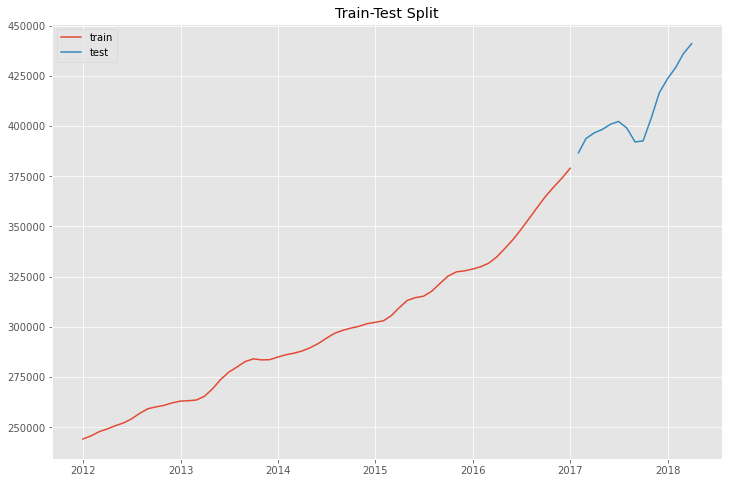

In [115]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_two.shape[0]*0.8)


train = seven_zero_two[:cutoff]

test = seven_zero_two[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split')
plt.legend();

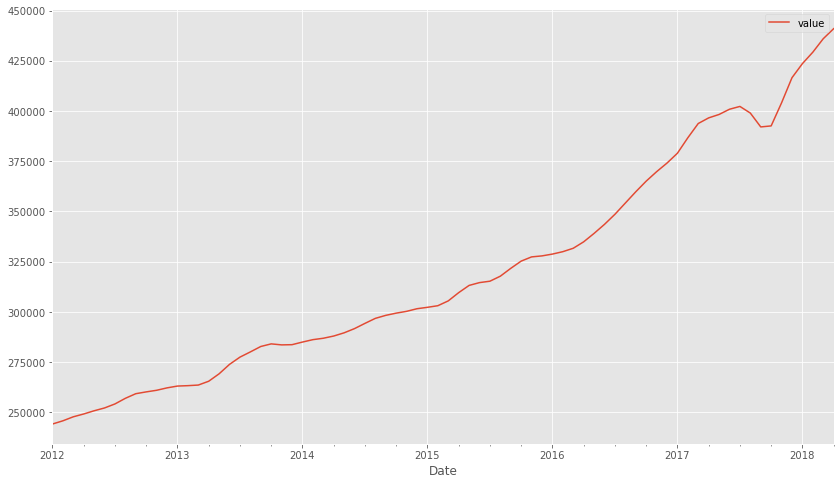

In [116]:
seven_zero_two.plot(figsize=(14,8))
plt.show()

### ACF & PACF

- The time series trends positively, with a small decline in mid 2017. However, it increases a couple of months later. 
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

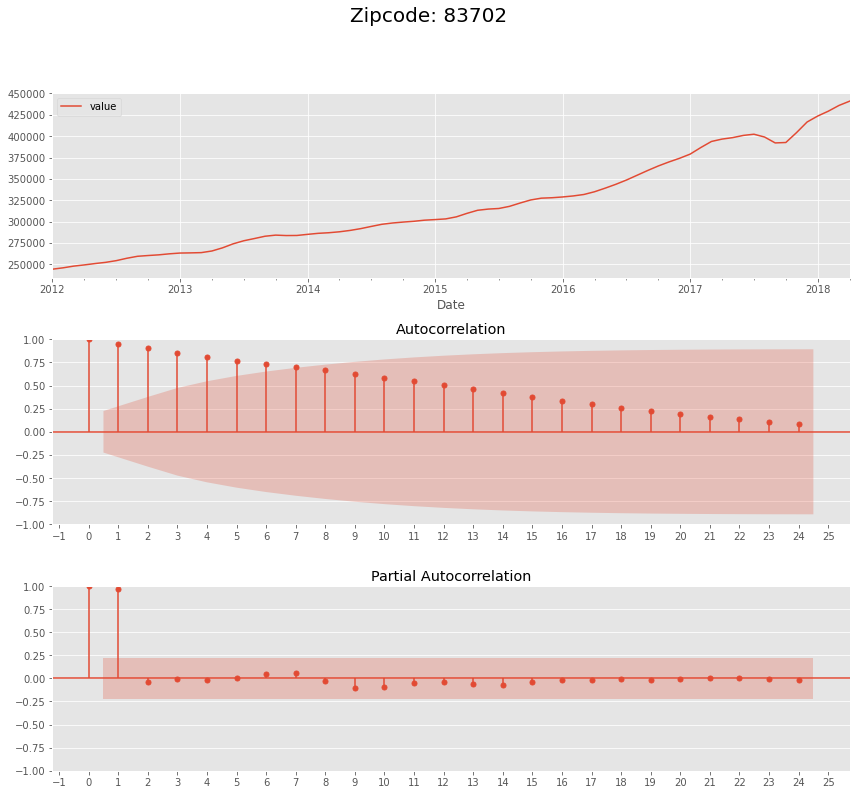

In [117]:
plot_acf_pacf(seven_zero_two, zipcode= '83702')
plt.show()

### Parameter selection for the ARIMA time series model

In [118]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [119]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1686.1456433389528
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=784354.6742572291
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1113.9412483107267
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=840.6797209181717
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1004.0643976827877
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=987.5110341334399
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=775.1590882069529
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=1081.5161967960755
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=62944.822576005405
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=799657.1425231297
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1066.4150991736715
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=976.2209874984102
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1333.2210704768204
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1281.0418984325484
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=829.7538044306043
AR

### Fitting the time series model - ARIMA

In [120]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic            589.71
Name: 54, dtype: object

- The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `589.71`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -463.705
Date:                            Mon, 13 Feb 2023   AIC                            933.410
Time:                                    09:35:44   BIC                            939.146
Sample:                                01-01-2012   HQIC                           935.595
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6703      0.060     11.107      0.000       0.552       0.789
ar.S.L12      -0.3657      0.354     -1.032      0.302      -1.060       0.329
sigma2      5.823e+06   7.65e+05      7.612      0.000    4.32e+06    7.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.36   Jarque-Bera (JB):                52.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.53   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

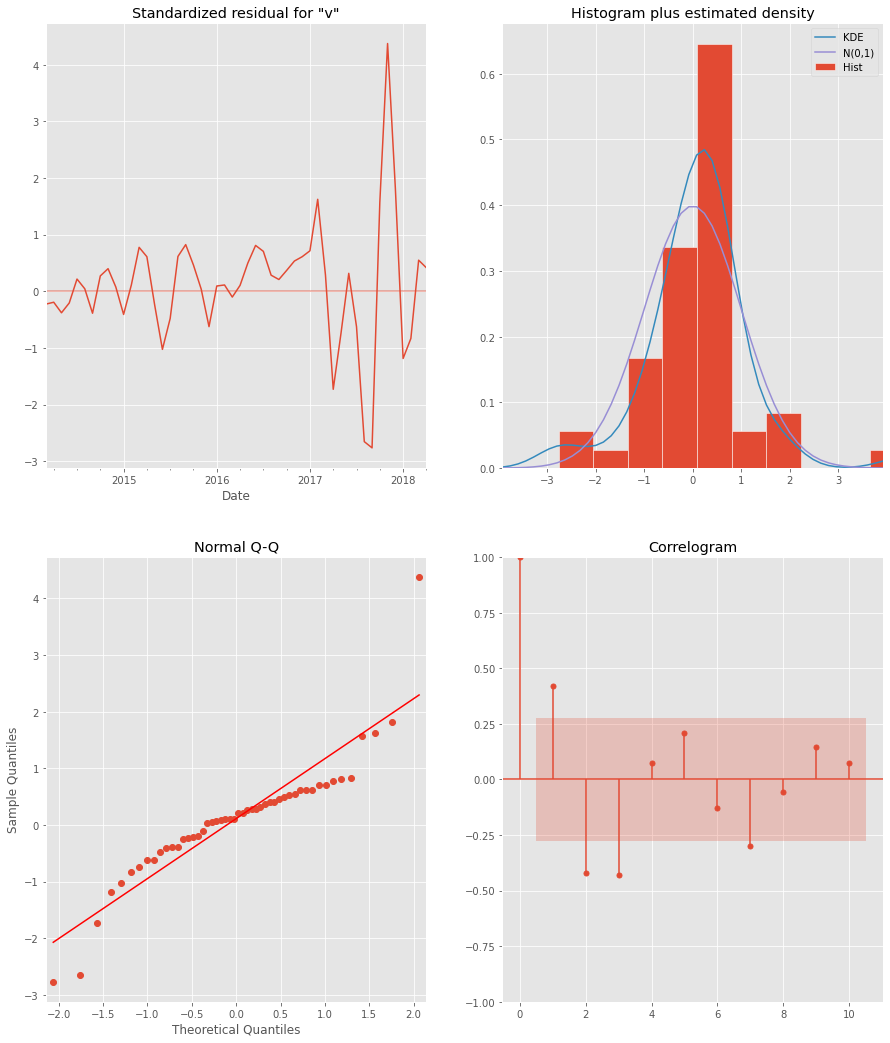

In [121]:
output = fit_SARIMAX_model(seven_zero_two, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: Shows noise rather than a pattern.  
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares away from the line. 
- **Correlogram**: There are four spikes outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

In [122]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

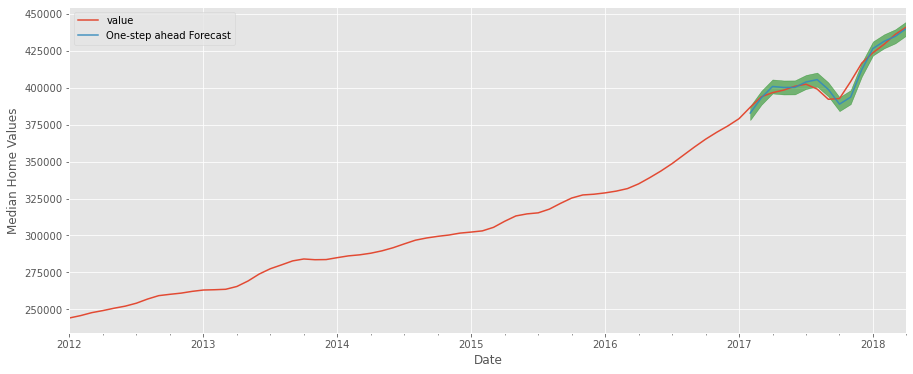

In [123]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_two['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecasted line shows an upwards trend. The lines are close but not exact. 

### Accuracy of our forecast with Root Mean Squared Error

In [124]:
# Get the real and predicted values
seven_zero_two_forecasted = pred.predicted_mean
seven_zero_two_truth = seven_zero_two.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_two_forecasted - seven_zero_two_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 3457.07


- The RMSE of 3457.07 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 3457.07 dollars from the actual values. 

- AIC = 589.71

### Dynamic Forecasting

In [125]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

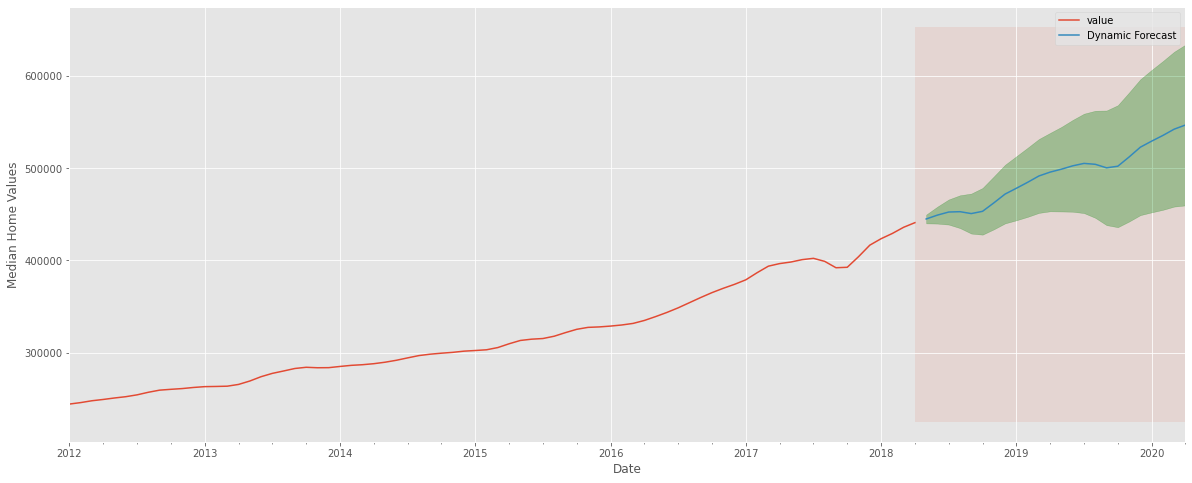

In [126]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_two['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_two_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

### Producing and visualizing forecasts

In [127]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,440261.073496,449720.562312,444990.817904
2018-06-01,440000.681972,458416.003897,449208.342935
2018-07-01,438931.468256,466155.167789,452543.318022
2018-08-01,435125.715234,470699.376898,452912.546066
2018-09-01,429176.702979,472546.464773,450861.583876


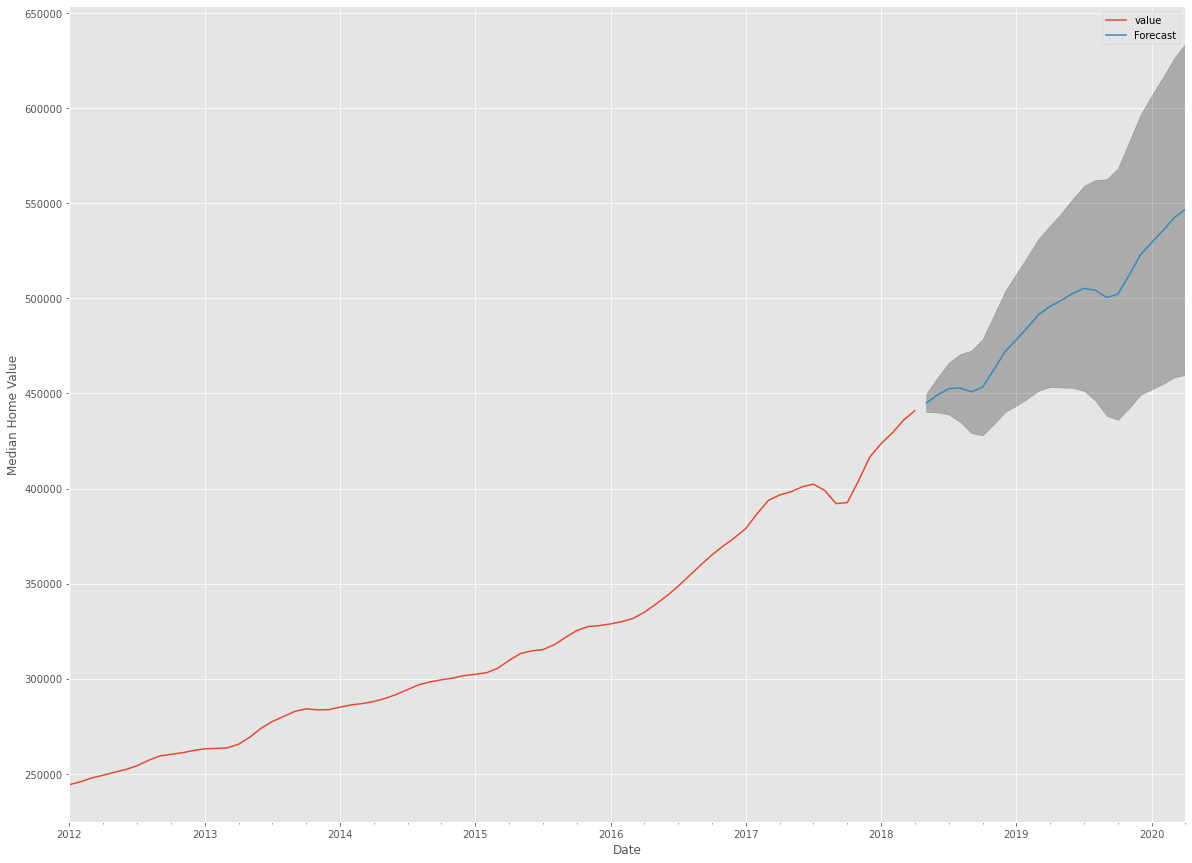

In [128]:
# Plot future predictions with confidence intervals
ax = seven_zero_two.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [129]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-1.062886,1.062886,0.000000
2018-06-01,-1.121402,3.016958,0.947778
2018-07-01,-1.361680,4.756132,1.697226
2018-08-01,-2.216923,5.777323,1.780200
2018-09-01,-3.553807,6.192408,1.319300
2018-10-01,-3.818827,7.554791,1.867982
2018-11-01,-2.521042,10.364116,3.921537
2018-12-01,-1.070764,13.221792,6.075514
2019-01-01,-0.315333,15.292547,7.488607
2019-02-01,0.521144,17.363539,8.942341


## Results: 

In [130]:
results.Two_YR_ROI_Percentage[4] = roi['mean'][-1]
results.head()

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,22


- ZipCode 83702 possess the new highest 2 year ROI

## 83713

In [131]:
seven_one_three = boise_grouped.loc[83713]
seven_one_three.head()

,value
Date,
2012-01-01,144200.0
2012-02-01,144600.0
2012-03-01,145000.0
2012-04-01,146000.0
2012-05-01,147300.0


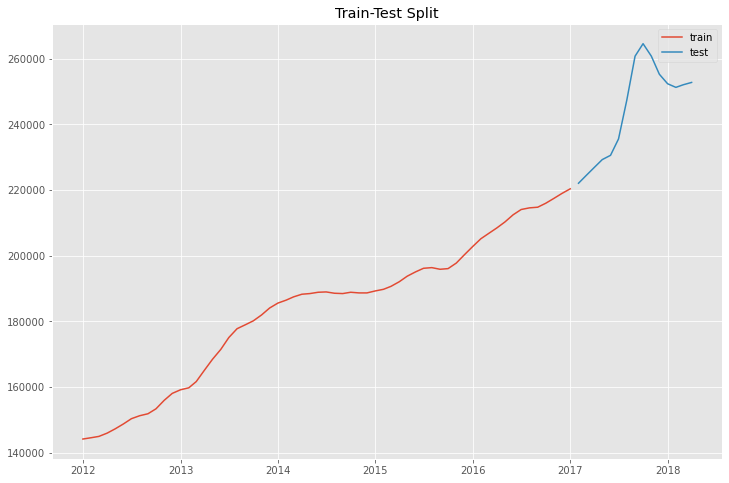

In [132]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_one_three.shape[0]*0.8)


train = seven_one_three[:cutoff]

test = seven_one_three[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

### ACF & PACF

- The time series trends positively. Where some zipcodes showed decrease in mid 2017, this zipcode showed an increased spike in mid 2017.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

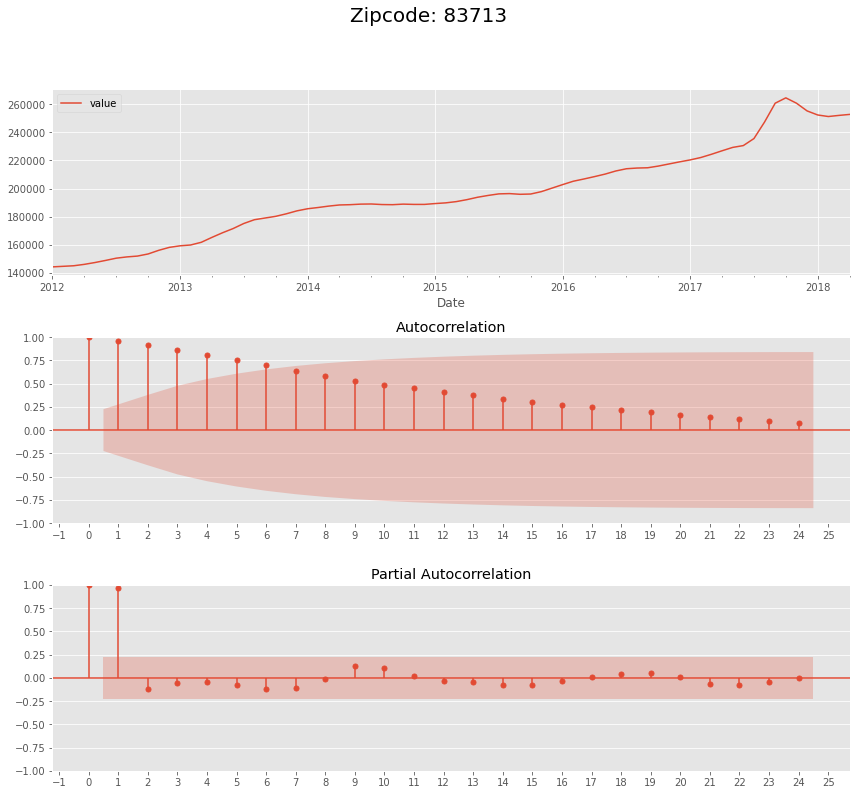

In [133]:
plot_acf_pacf(seven_one_three, zipcode= '83713')
plt.show()

### Parameter selection for the ARIMA time series model

In [134]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [135]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1628.1425960843765
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=275970.8688547062
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1075.7792495234523
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=796.6440676122734
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1028.1752237483383
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=993.4179579789773
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=797.3903141187725
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=776.4722922906702
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=1561.6861731671518
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=253338.04676286696
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1064.4872980677856
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1158.278358913908
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1377.3622075095016
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1307.7725987404674
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=812.0646389167508
AR

### Fitting the time series model - ARIMA

In [136]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           554.909
Name: 54, dtype: object

- The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `554.909`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -457.082
Date:                            Mon, 13 Feb 2023   AIC                            920.165
Time:                                    09:35:53   BIC                            925.901
Sample:                                01-01-2012   HQIC                           922.349
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7082      0.047     15.158      0.000       0.617       0.800
ar.S.L12      -0.3636      0.592     -0.614      0.539      -1.524       0.797
sigma2      5.103e+06   5.21e+05      9.792      0.000    4.08e+06    6.12e+06
===================================================================================
Ljung-Box (L1) (Q):                  12.63   Jarque-Bera (JB):                90.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.38   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

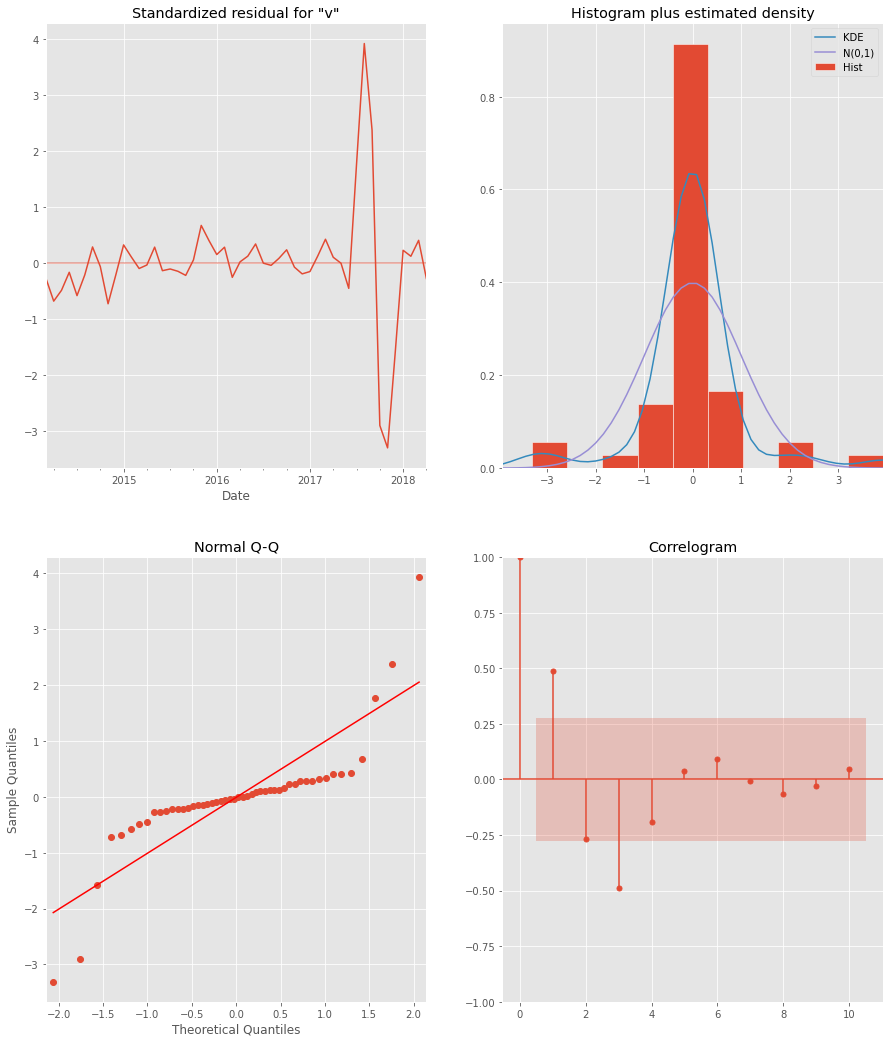

In [137]:
output = fit_SARIMAX_model(seven_one_three, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: Pattern seems to be random noise. 
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares away from the line. 
- **Correlogram**: There are two spikes outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

In [138]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

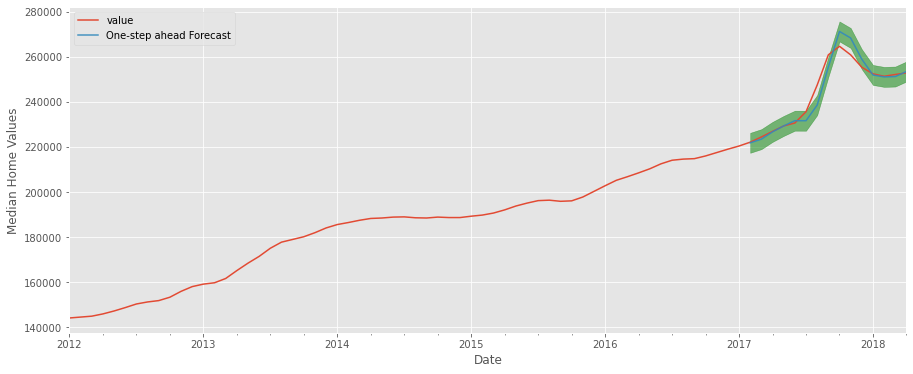

In [139]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_one_three['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- Forcasted line follows the true values till about mid 2017, then begins to vary off the line till 2018. However, it still maintains the upward trend. 

### Accuracy of our forecast with Root Mean Squared Error

In [140]:
# Get the real and predicted values
seven_one_three_forecasted = pred.predicted_mean
seven_one_three_truth = seven_one_three.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_one_three_forecasted - seven_one_three_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 2711.26


- The RMSE of 2711.26 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 2711.26 dollars from the actual values. 

- AIC = 554.909

### Dynamic Forecasting

In [141]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

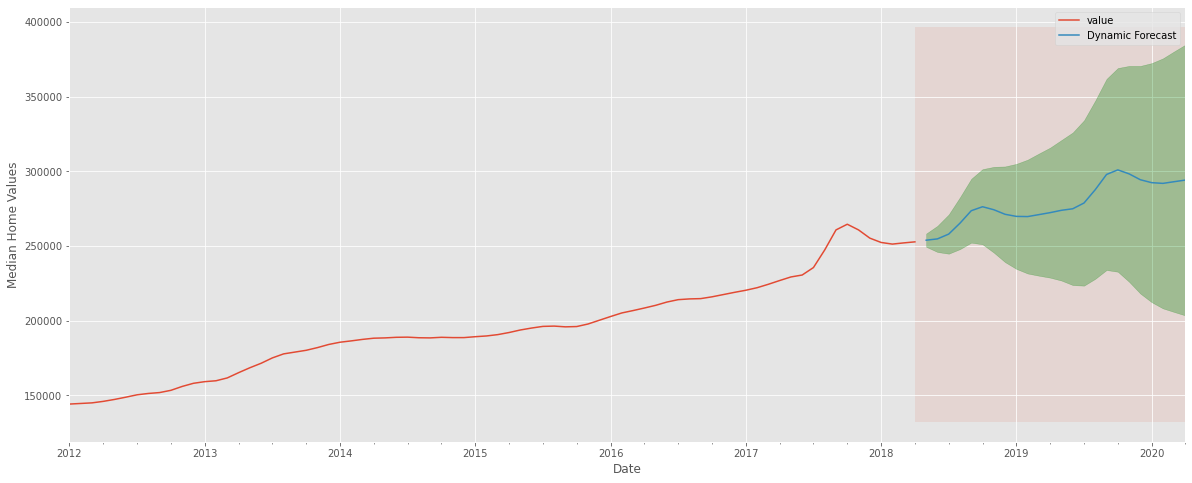

In [142]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_one_three['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_one_three_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

### Producing and visualizing forecasts

In [143]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,249485.367111,258340.788329,253913.077720
2018-06-01,246019.344632,263547.603519,254783.474076
2018-07-01,244875.646829,271146.488910,258011.067870
2018-08-01,247958.049170,282686.557113,265322.303142
2018-09-01,252275.027807,295031.751631,273653.389719


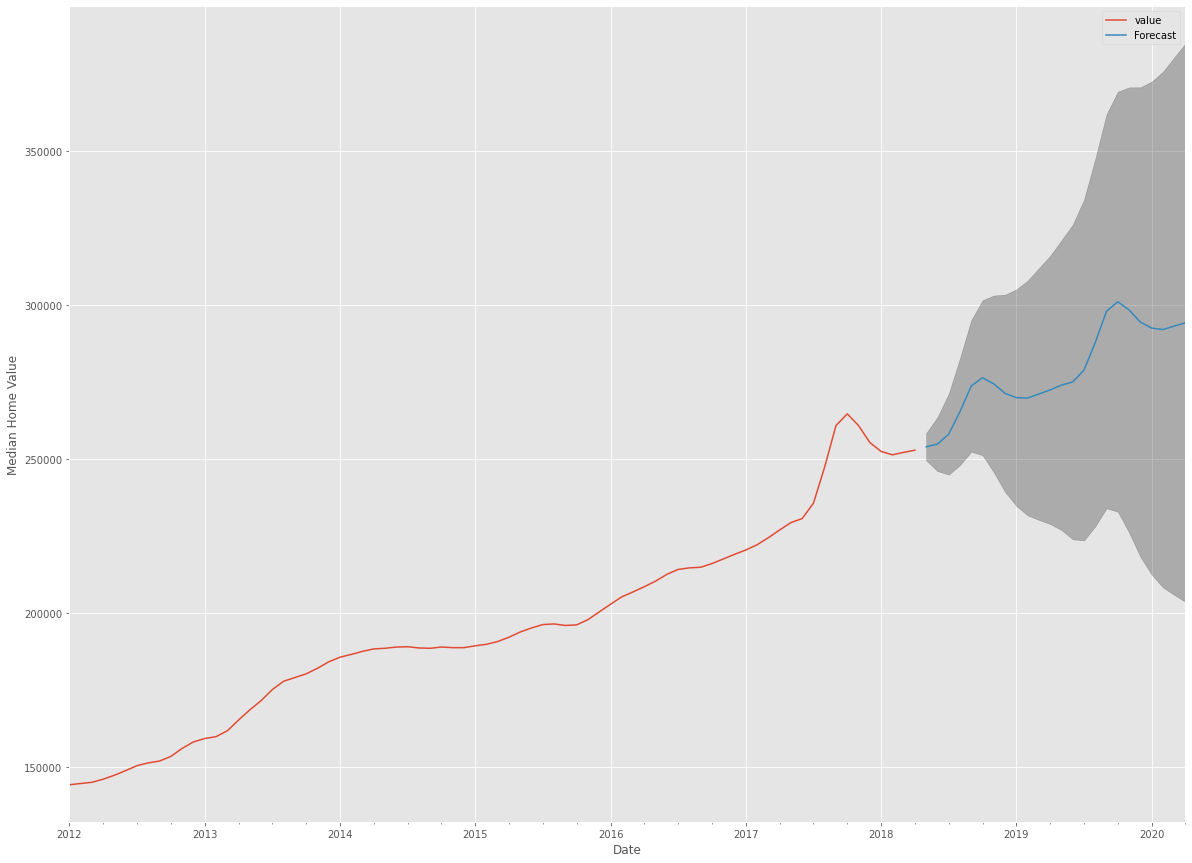

In [144]:
# Plot future predictions with confidence intervals
ax = seven_one_three.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- - Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [145]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-1.743790,1.743790,0.000000
2018-06-01,-3.108833,3.794419,0.342793
2018-07-01,-3.559262,6.787130,1.613934
2018-08-01,-2.345302,11.332019,4.493359
2018-09-01,-0.645122,16.193996,7.774437
2018-10-01,-1.083837,18.731174,8.823669
2018-11-01,-3.270710,19.336769,8.033029
2018-12-01,-5.782070,19.445732,6.831831
2019-01-01,-7.566463,20.124259,6.278898
2019-02-01,-8.778040,21.233677,6.227819


## Results: 

In [146]:
results.Two_YR_ROI_Percentage[5] = roi['mean'][-1]
results

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,22
5,83713,15
6,83703,1
7,83716,1
8,83712,1


## 83703

In [147]:
seven_zero_three = boise_grouped.loc[83703]
seven_zero_three.head()

,value
Date,
2012-01-01,138200.0
2012-02-01,139200.0
2012-03-01,139900.0
2012-04-01,140300.0
2012-05-01,141700.0


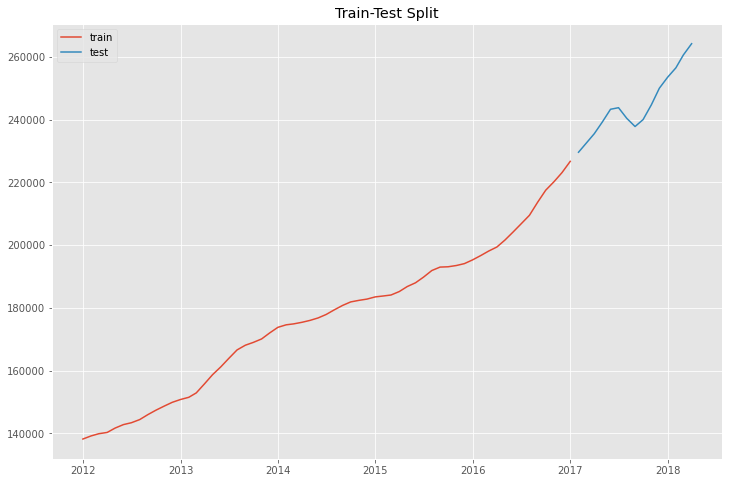

In [148]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_zero_three.shape[0]*0.8)


train = seven_zero_three[:cutoff]

test = seven_zero_three[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split')
plt.legend();

### ACF & PACF

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

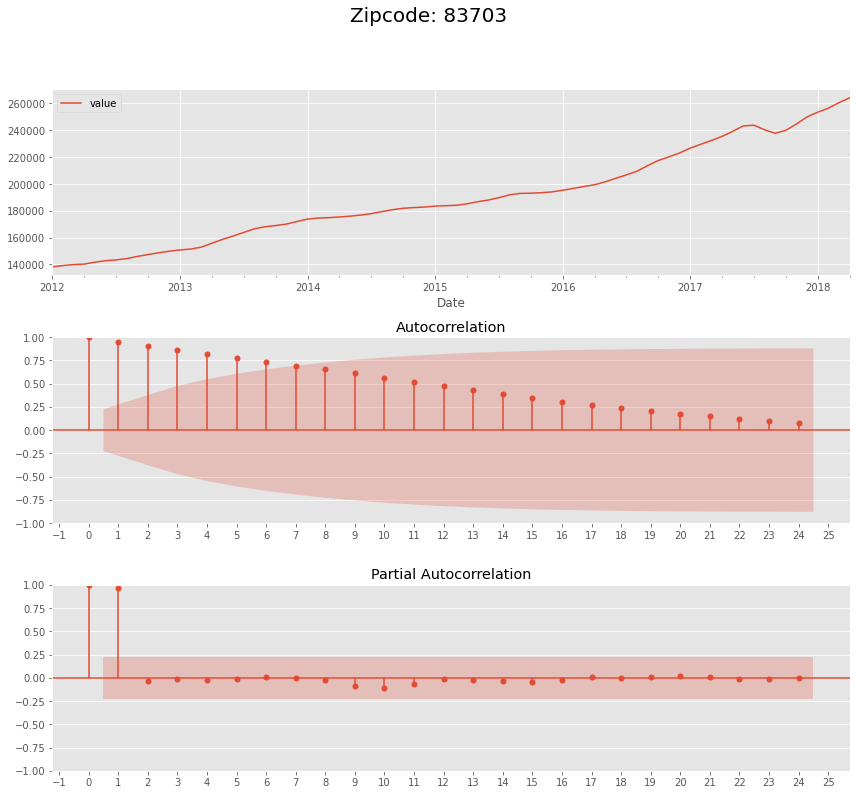

In [149]:
plot_acf_pacf(seven_zero_three, zipcode= '83703')
plt.show()

### Parameter selection for the ARIMA time series model

In [150]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [151]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1623.584045901746
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=252943.50742124743
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1074.5270714884796
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=804.9214168941845
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=992.1418183244257
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=965.7228938306521
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=780.0675239972403
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=1021.9890463839862
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=21709.234776682188
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=261299.75263646984
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1027.9386299004423
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=738.9599062417942
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1282.3202243762853
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1312.197608273533
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=805.3546397528573
ARI

### Fitting the time series model - ARIMA

In [152]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           544.537
Name: 54, dtype: object

- The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `544.537`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -427.712
Date:                            Mon, 13 Feb 2023   AIC                            861.423
Time:                                    09:36:03   BIC                            867.159
Sample:                                01-01-2012   HQIC                           863.607
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7362      0.090      8.144      0.000       0.559       0.913
ar.S.L12      -0.5052      0.335     -1.508      0.131      -1.162       0.151
sigma2      1.554e+06   1.83e+05      8.506      0.000     1.2e+06    1.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.47   Jarque-Bera (JB):                53.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.34   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

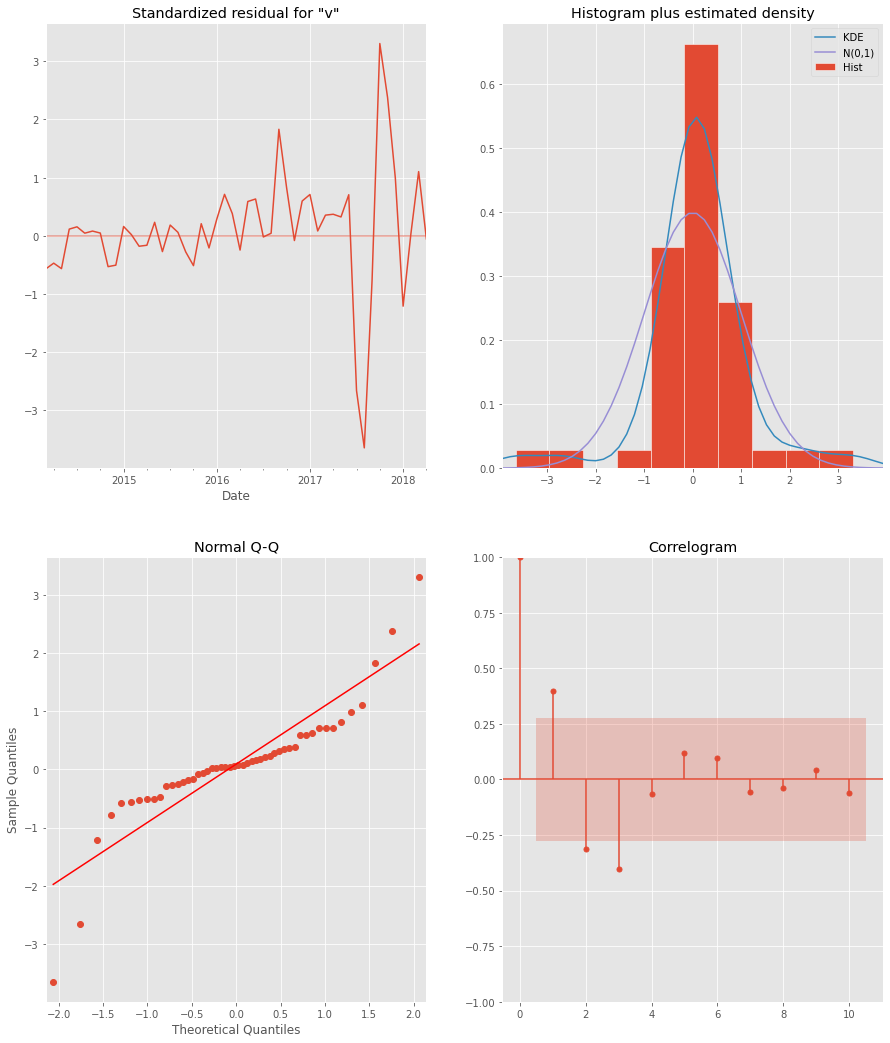

In [153]:
output = fit_SARIMAX_model(seven_zero_three, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: Pattern seems to be random.
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares away from the line. 
- **Correlogram**: There are three spikes outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

In [154]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

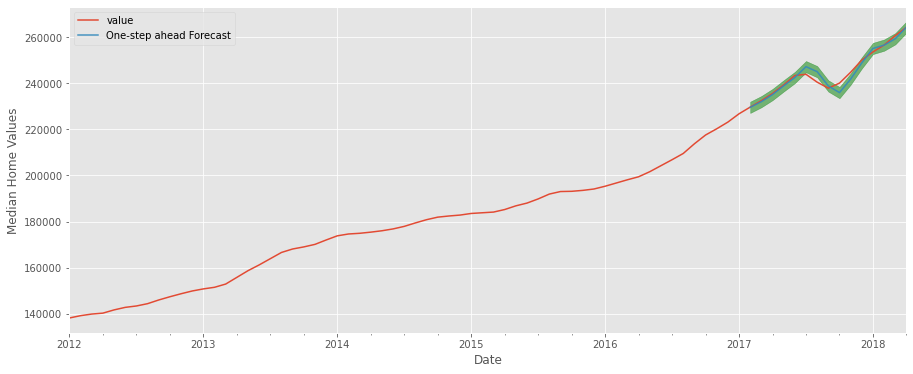

In [155]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_zero_three['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecast deviates from the true value line slightly. But continues an upward positive trend.

### Accuracy of our forecast with Root Mean Squared Error

In [156]:
# Get the real and predicted values
seven_zero_three_forecasted = pred.predicted_mean
seven_zero_three_truth = seven_zero_three.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_zero_three_forecasted - seven_zero_three_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 1495.92


- The RMSE of 1495.92 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 1495.92 dollars from the actual values. 

- AIC = 544.537

### Dynamic Forecasting

In [157]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

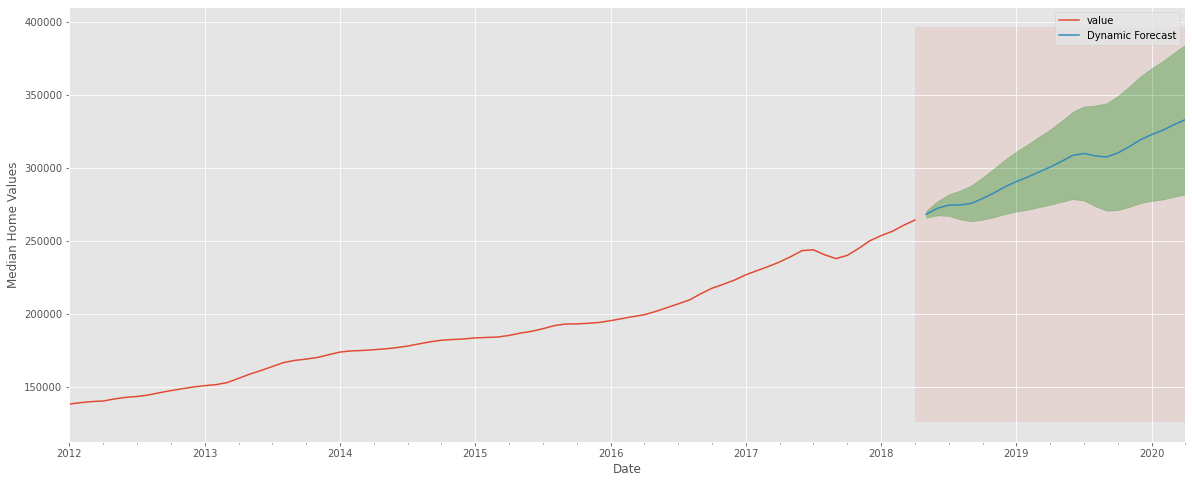

In [158]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_zero_three['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_zero_three_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

### Producing and visualizing forecasts

In [159]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,265736.324939,270623.098412,268179.711675
2018-06-01,267390.202119,277181.151165,272285.676642
2018-07-01,266996.182034,281821.702000,274408.942017
2018-08-01,264618.693988,284390.842727,274504.768358
2018-09-01,263380.351675,287909.734507,275645.043091


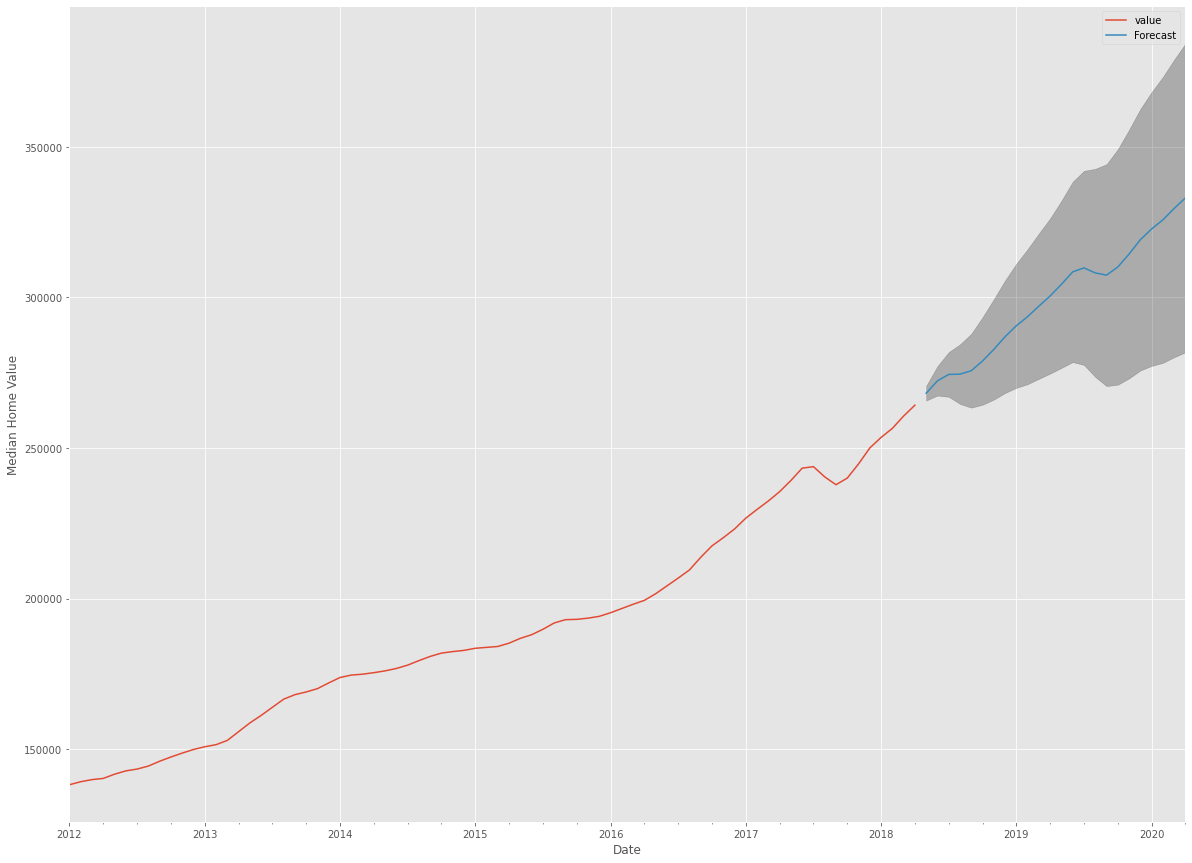

In [160]:
# Plot future predictions with confidence intervals
ax = seven_zero_three.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [161]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-0.911101,0.911101,0.000000
2018-06-01,-0.294396,3.356495,1.531050
2018-07-01,-0.441320,5.086884,2.322782
2018-08-01,-1.327848,6.044876,2.358514
2018-09-01,-1.789606,7.357015,2.783705
2018-10-01,-1.428091,9.406339,3.989124
2018-11-01,-0.789667,11.642615,5.426474
2018-12-01,0.024805,13.967100,6.995952
2019-01-01,0.668499,16.038016,8.353257
2019-02-01,1.117514,17.837761,9.477638


## Results: 

In [162]:
results.Two_YR_ROI_Percentage[6] = roi['mean'][-1]
results

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,22
5,83713,15
6,83703,24
7,83716,1
8,83712,1


- ZipCode 83703 now has the highest 2 year ROI. 

## 83716

In [163]:
seven_one_six = boise_grouped.loc[83716]
seven_one_six.head()

,value
Date,
2012-01-01,200900.0
2012-02-01,201900.0
2012-03-01,203000.0
2012-04-01,204100.0
2012-05-01,205500.0


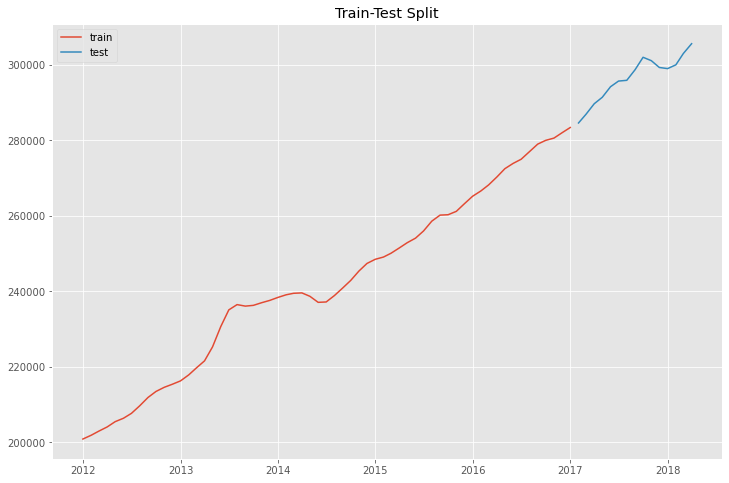

In [164]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_one_six.shape[0]*0.8)


train = seven_one_six[:cutoff]

test = seven_one_six[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

### ACF & PACF 

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

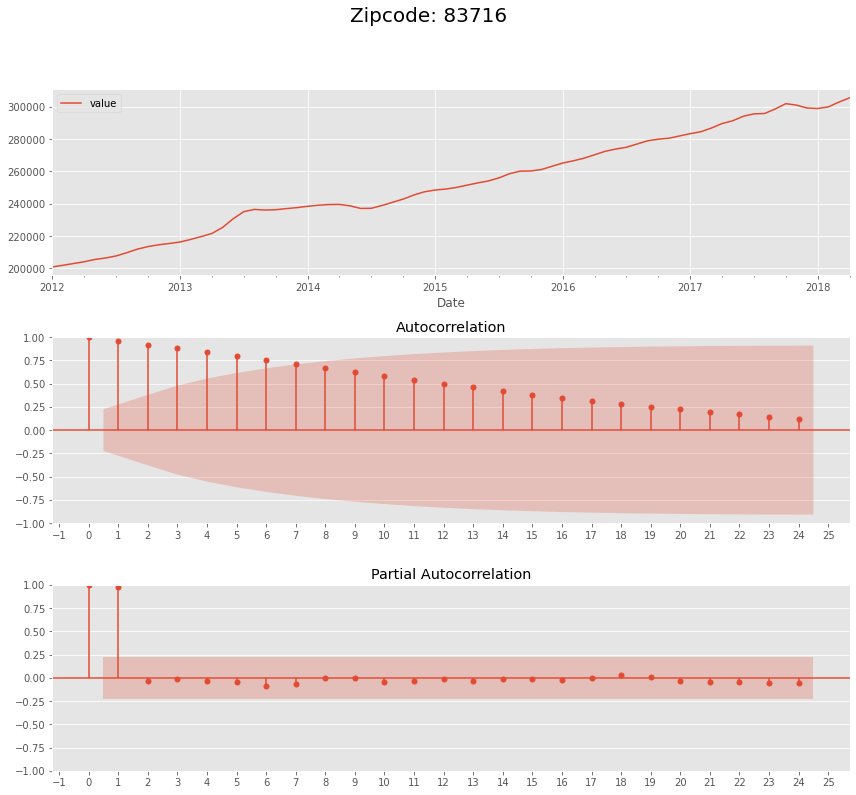

In [165]:
plot_acf_pacf(seven_one_six, zipcode= '83716')
plt.show()


### Parameter selection for the ARIMA time series model

In [166]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [167]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1660.8221458775483
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=527461.2717030417
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1077.6764448833142
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=802.4682357555248
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=998.6773911334728
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=1043.455994456163
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=790.2263627125046
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=770.0706962430507
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=1593.6994469888
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=484452.5392138948
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1069.2679470921073
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1183.6008694582154
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1410.280168560844
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1338.3452804470255
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=808.1279947446365
ARIMA (

### Fitting the time series model - ARIMA

In [168]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (1, 1, 0, 12)
aic           582.942
Name: 54, dtype: object

The output of our code suggests that `ARIMA (1, 1, 0) x (1, 1, 0, 12)` yields the lowest AIC value of `582.942`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   76
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -424.887
Date:                            Mon, 13 Feb 2023   AIC                            855.775
Time:                                    09:36:13   BIC                            861.511
Sample:                                01-01-2012   HQIC                           857.959
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5813      0.102      5.725      0.000       0.382       0.780
ar.S.L12      -0.5006      0.133     -3.774      0.000      -0.761      -0.241
sigma2      1.408e+06   2.56e+05      5.490      0.000    9.05e+05    1.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.19   Jarque-Bera (JB):                 5.13
Prob(Q):                              0.07   Prob(JB):                         0.08
Heteroskedasticity (H):               1.73   Skew:                            -0.73
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

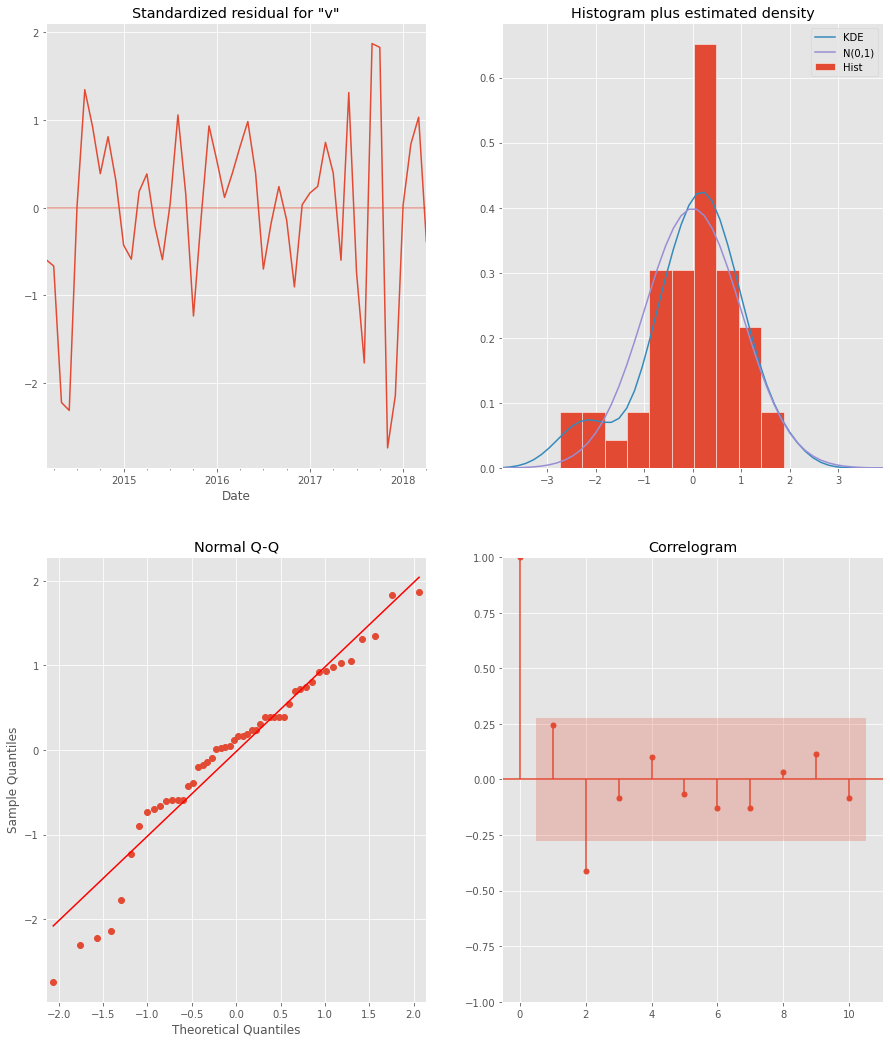

In [169]:
output = fit_SARIMAX_model(seven_one_six, (1, 1, 0), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: Pattern appears to be random.  
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares slightly away from the line. 
- **Correlogram**: There is one spike outside of the shaded area. This means there could be some missed seasonality component.

### Validating the model: One-step ahead forecasting

In [170]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

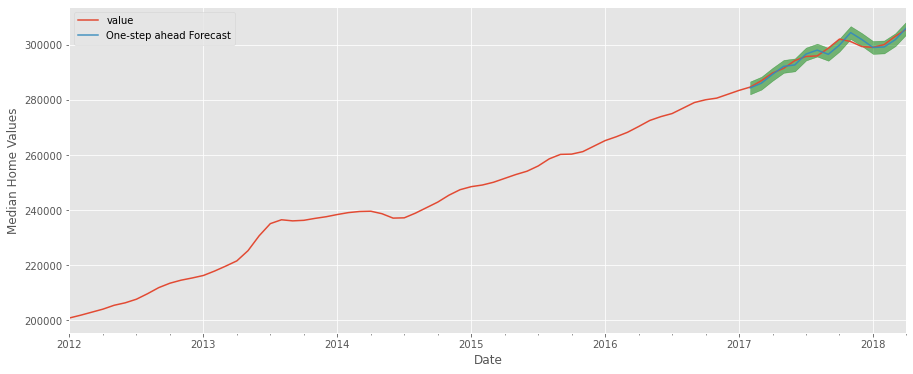

In [171]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_one_six['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

- The forecasted line varies off the true line slightly. 

### Accuracy of our forecast with Root Mean Squared Error

In [172]:
# Get the real and predicted values
seven_one_six_forecasted = pred.predicted_mean
seven_one_six_truth = seven_one_six.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_one_six_forecasted - seven_one_six_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 1309.59


- The RMSE of 1309.59 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 1309.59
dollars from the actual values. 

- AIC = 582.942

### Dynamic Forecasting

In [173]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

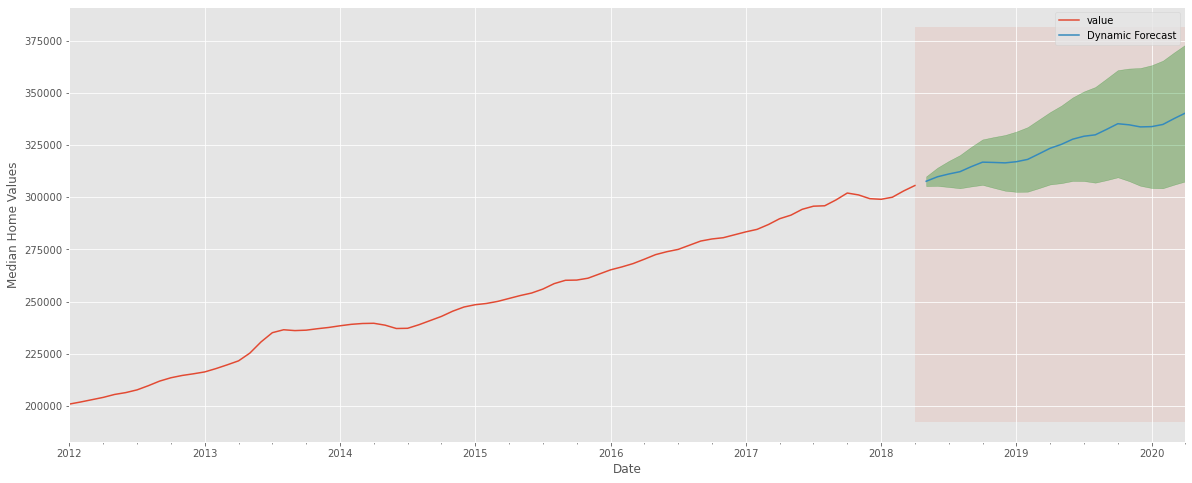

In [174]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_one_six['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_one_six_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

### Producing and visualizing forecasts

In [175]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,305312.169430,309963.384863,307637.777147
2018-06-01,305436.546515,314138.905372,309787.725944
2018-07-01,304883.633535,317350.419199,311117.026367
2018-08-01,304294.021838,320176.689584,312235.355711
2018-09-01,305160.187928,324129.478983,314644.833455


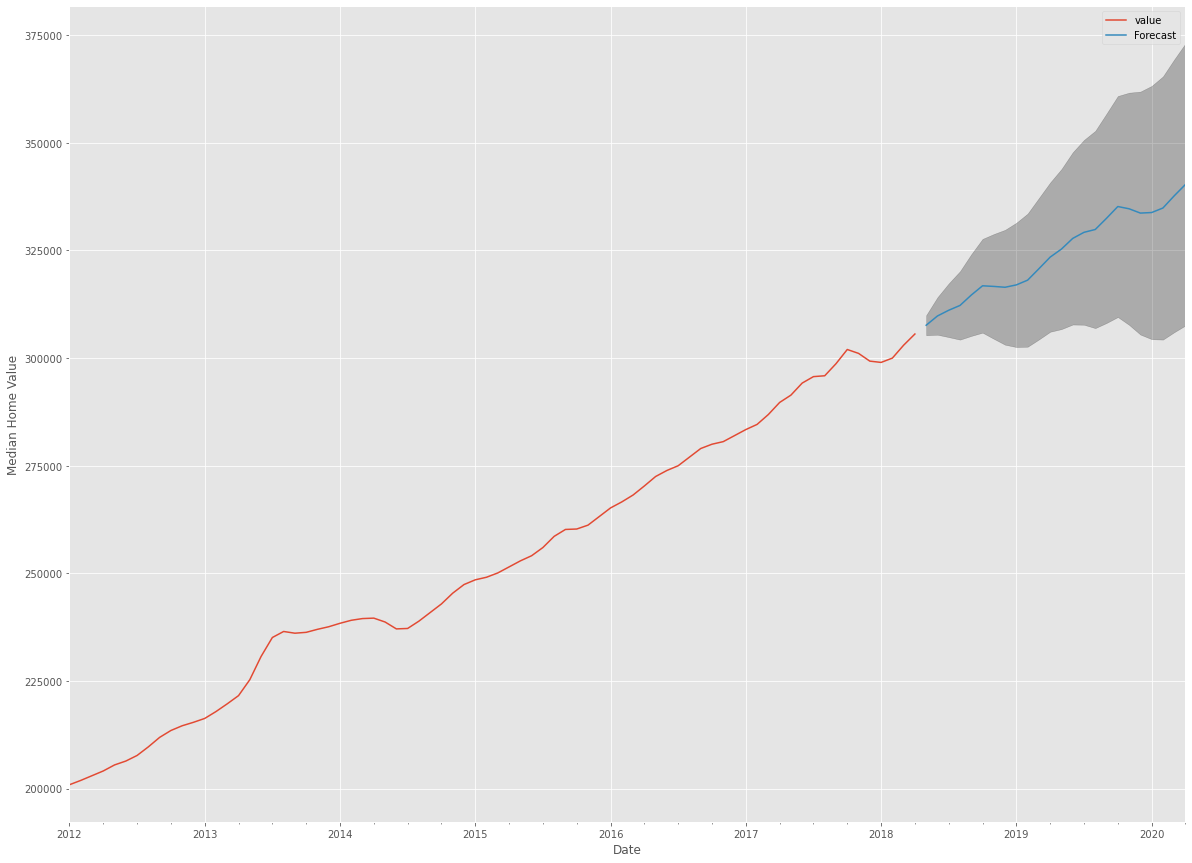

In [176]:
# Plot future predictions with confidence intervals
ax = seven_one_six.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

- Our forecasts show that the time series is expected to continue increasing at a steady pace. 

## Average Return on Investment (ROI)

In [177]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-0.755956,0.755956,0.000000
2018-06-01,-0.715527,2.113241,0.698857
2018-07-01,-0.895255,3.157168,1.130956
2018-08-01,-1.086913,4.075869,1.494478
2018-09-01,-0.805359,5.360753,2.277697
2018-10-01,-0.560184,6.516147,2.977981
2018-11-01,-1.023371,6.884633,2.930631
2018-12-01,-1.470107,7.203948,2.866921
2019-01-01,-1.646199,7.739050,3.046425
2019-02-01,-1.620912,8.429404,3.404246


## Results: 

In [178]:
results.Two_YR_ROI_Percentage[7] = roi['mean'][-1]
results

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,22
5,83713,15
6,83703,24
7,83716,10
8,83712,1


## 83712

In [179]:
seven_one_two = boise_grouped.loc[83712]
seven_one_two.head()

,value
Date,
2012-01-01,254500.0
2012-02-01,255900.0
2012-03-01,257200.0
2012-04-01,258800.0
2012-05-01,261000.0


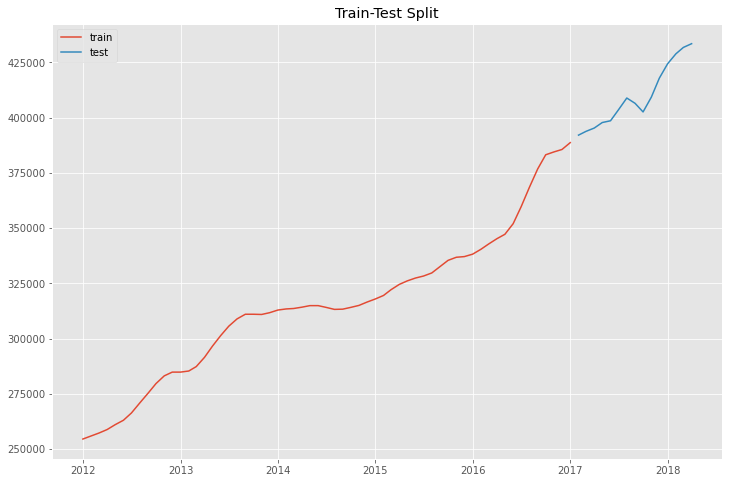

In [180]:
# find the index which allows us to split off 20% of the data
cutoff = round(seven_one_two.shape[0]*0.8)


train = seven_one_two[:cutoff]

test = seven_one_two[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend()

### ACF & PACF

- The time series trends positively.
- The ACF graph shows a slight decrease over time due to trend.
- The PACF graph shows a spike at 1 which would suggest an AR value of 1.

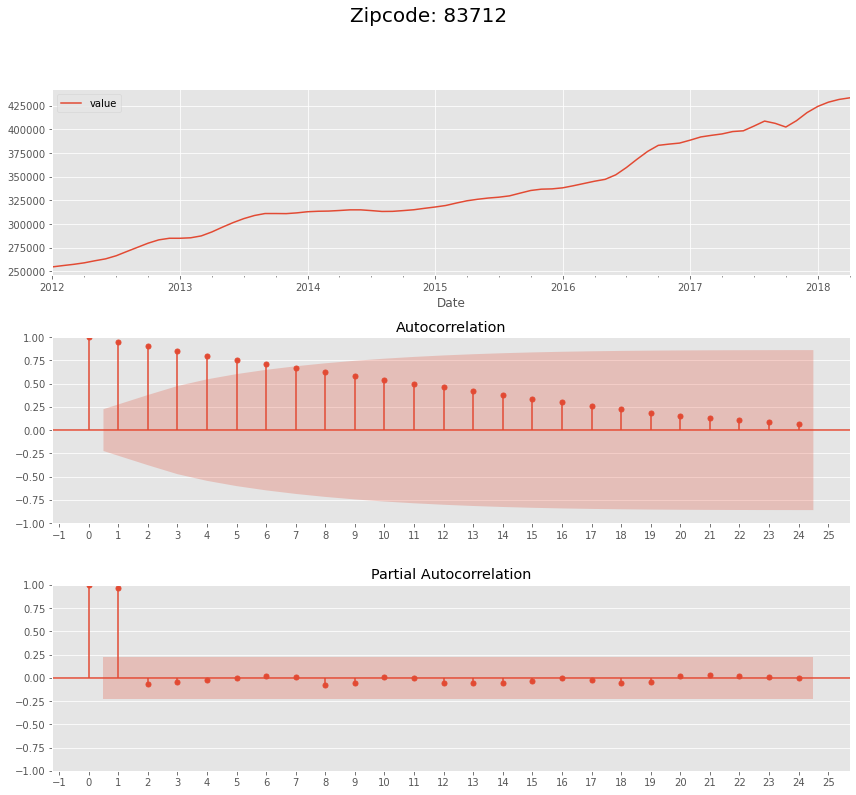

In [181]:
plot_acf_pacf(seven_one_two, zipcode = '83712')
plt.show()

### Parameter selection for the ARIMA time series model

In [182]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [183]:
ans = find_best_SARIMAX(train, pdq, pdqs)

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=1692.67663938338
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=878813.8259811348
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1119.1960507803578
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=834.5533492869502
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1074.9257835633207
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=1043.0213227294346
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=836.4552310019072
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=805.0582410746699
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=68027.80529151598
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=919413.0041551843
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1112.9888718177958
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1257.9003843940327
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=1338.6567470915163
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=1375.4418121997676
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=833.4152712933252
ARIM

### Fitting the time series model - ARIMA

In [184]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 0, 12)
aic           603.165
Name: 62, dtype: object

The output of our code suggests that `ARIMA (1, 1, 1) x (1, 1, 0, 12)` yields the lowest AIC value of `603.165`. We should therefore consider this to be optimal option out of all the models we have considered.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -459.384
Date:                             Mon, 13 Feb 2023   AIC                            926.768
Time:                                     09:36:23   BIC                            934.416
Sample:                                 01-01-2012   HQIC                           929.681
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4293      0.176      2.446      0.014       0.085       0.773
ma.L1          0.6294      0.173      3.635      0.000       0.290       0.969
ar.S.L12      -0.0034      0.031     -0.109      0.913      -0.064       0.057
sigma2      5.047e+06   9.27e+05      5.444      0.000    3.23e+06    6.86e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               123.76
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               9.69   Skew:                             1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

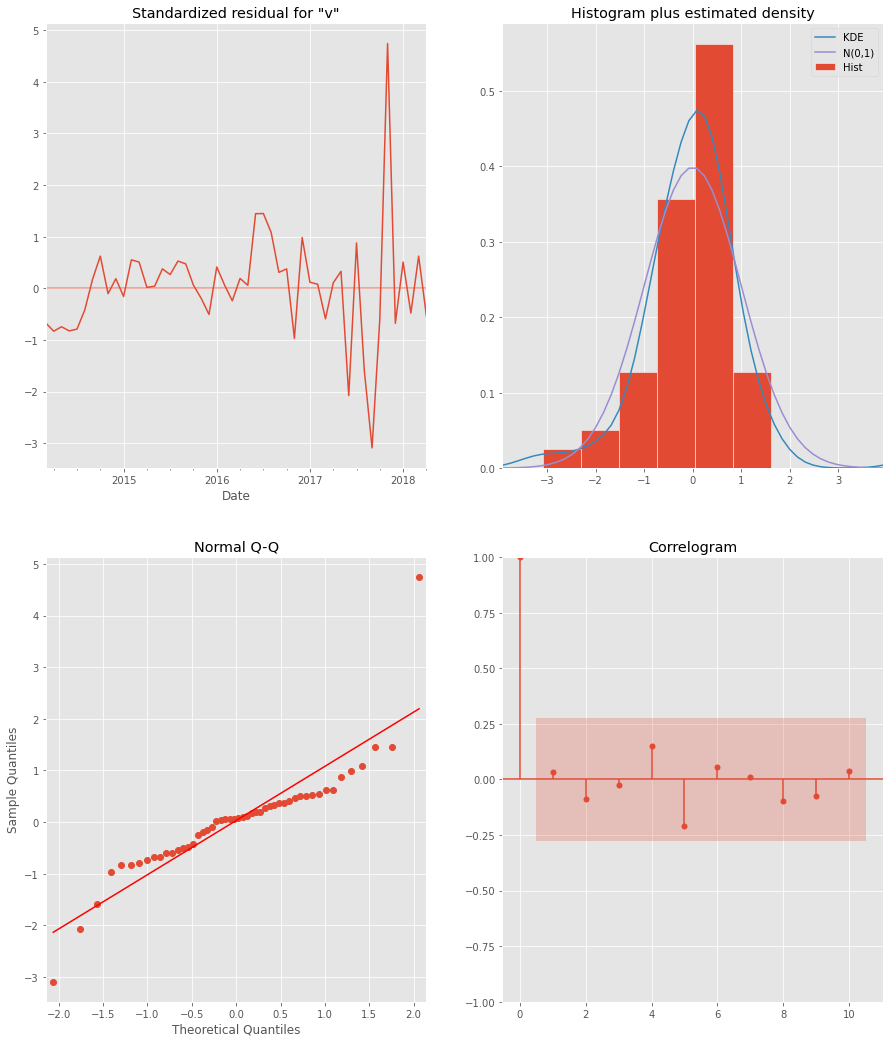

In [185]:
output = fit_SARIMAX_model(seven_one_two, (1, 1, 1), (1, 1, 0, 12))
output.summary()

- **Standardized residual**: The pattern appears to be random.  
- **Histogram**: The histogram shows that the distribution appears to be pretty close to normal. 
- **QQ-plot**: QQ-plot flares away from the line. 
- **Correlogram**: The points in the correlogram fall inside the box and do not indidcate a missed seasonality component.

### Validating the model: One-step ahead forecasting

In [186]:
# Get predictions starting from 01-01-2017 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-02-01'), dynamic=False)
pred_conf = pred.conf_int()

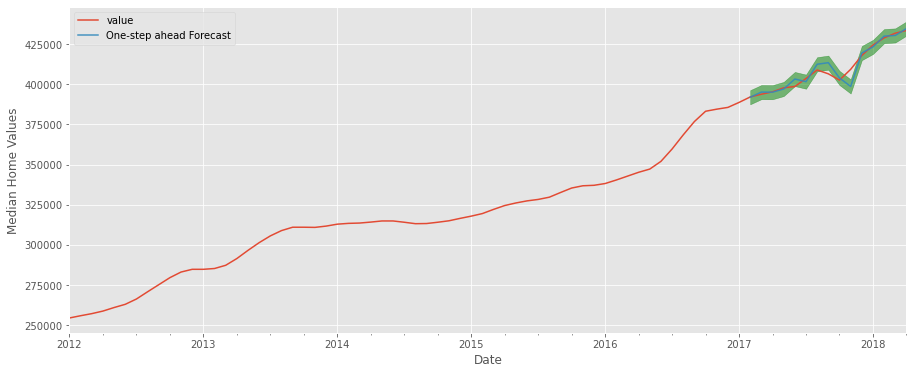

In [187]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = seven_one_two['2012-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy of our forecast with Root Mean Squared Error

In [188]:
# Get the real and predicted values
seven_one_two_forecasted = pred.predicted_mean
seven_one_two_truth = seven_one_two.loc['2017-02-01':].value

# Compute the mean square error
mse = np.sqrt((seven_one_two_forecasted - seven_one_two_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 2530.95


- The RMSE of 2530.95 in this case would indicate that, on average, the model's predictions for the mean value of homes in Boise, ID deviate by 2530.95 dollars from the actual values. 

- AIC = 603.165

### Dynamic Forecasting

In [189]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_forecast(steps=24)
pred_dynamic_conf = pred_dynamic.conf_int()

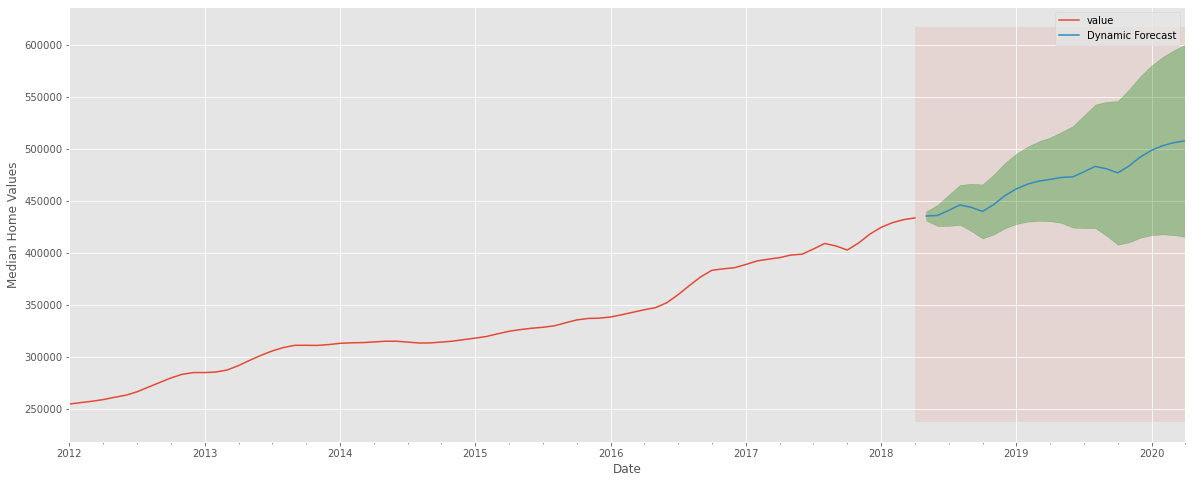

In [190]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.

ax = seven_one_two['2012':].plot(label='observed', figsize=(20, 8))

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-04-01'), seven_one_two_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()

### Producing and visualizing forecasts

In [191]:
# Get forecast 24 steps ahead in future.
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower value,upper value,mean
2018-05-01,430924.562106,439730.756438,435327.659272
2018-06-01,425775.532486,445930.983927,435853.258206
2018-07-01,425771.199078,455706.342398,440738.770738
2018-08-01,426859.755513,465135.323976,445997.539745
2018-09-01,420864.147035,466357.798021,443610.972528


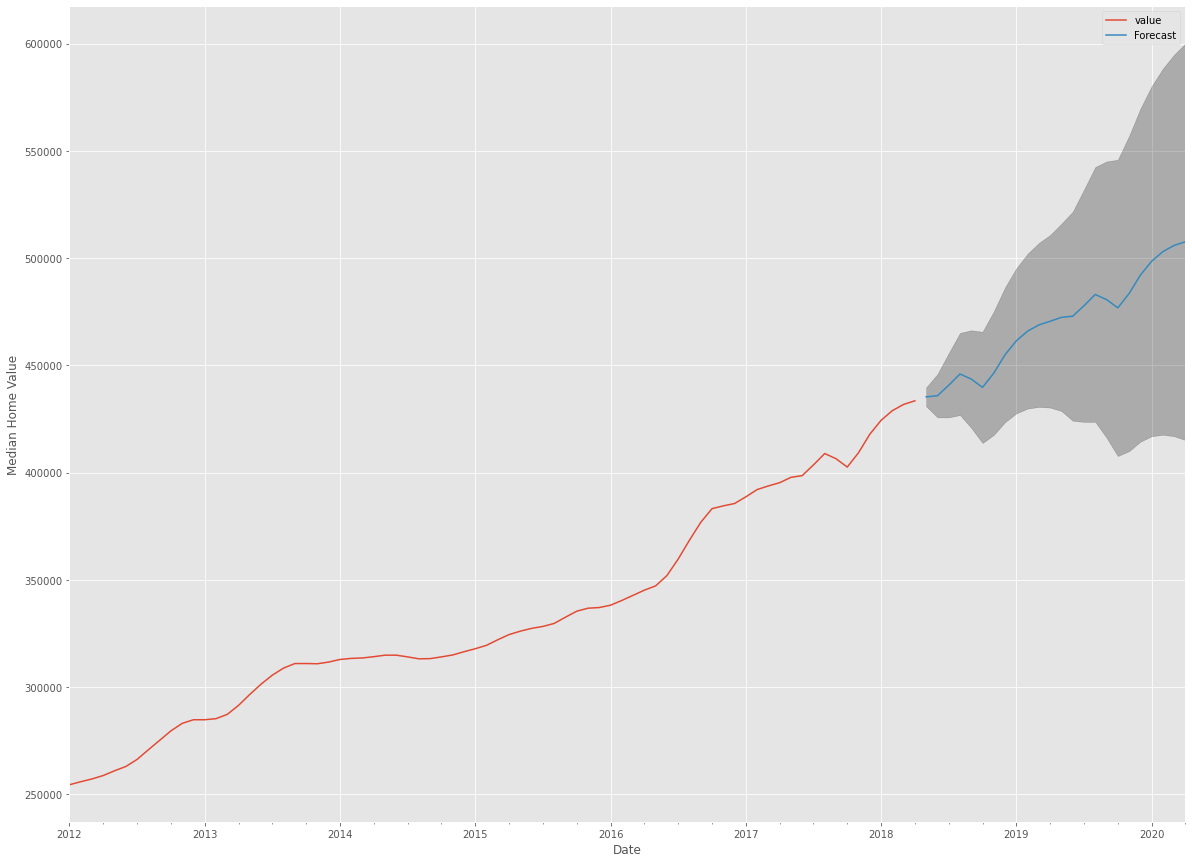

In [192]:
# Plot future predictions with confidence intervals
ax = seven_one_two.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

## Average Return on Investment (ROI)

In [193]:
#percentage over time is now the mean
#mean change percentage
cost = pred_conf.iloc[0]['mean']
roi = (pred_conf - cost)/ abs(cost) * 100

#pred_conf['result'] = pred_conf[''] - pred_conf['']

roi

,lower value,upper value,mean
2018-05-01,-1.011444,1.011444,0.000000
2018-06-01,-2.194238,2.435711,0.120736
2018-07-01,-2.195234,4.681229,1.242997
2018-08-01,-1.945179,6.847179,2.451000
2018-09-01,-3.322443,7.127996,1.902777
2018-10-01,-4.944378,6.969701,1.012662
2018-11-01,-4.068517,9.161654,2.546568
2018-12-01,-2.700181,11.731871,4.515845
2019-01-01,-1.765548,13.777851,6.006151
2019-02-01,-1.251718,15.329565,7.038924


## Results: 

In [194]:
results.Two_YR_ROI_Percentage[8] = roi['mean'][-1]
results

,Zipcode,Two_YR_ROI_Percentage
0,83709,14
1,83704,18
2,83706,18
3,83705,20
4,83702,22
5,83713,15
6,83703,24
7,83716,10
8,83712,16


## Top 5 ZipCodes

In [195]:
top_5 = results.sort_values(by='Two_YR_ROI_Percentage', ascending=False).head()
top_5.reset_index(inplace=True)
top_5

,index,Zipcode,Two_YR_ROI_Percentage
0,6,83703,24
1,4,83702,22
2,3,83705,20
3,1,83704,18
4,2,83706,18


## Image of Boise ZipCodes

<img src="images/boise_zip.png">

# Conclusion
---

## ZipCode Recommendations

- The ROI percentage represents the appreciation in property value of a home in Boise, ID over a 2 year span. I believe even though we are just analyzing the ROI in the short term, the value of homes in Boise will continue to rise. 

- Though all top 5 zip codes have forecasted to be profitable, I recommend investing in properties in the 83703 first. The inital invest is low and the profit margin is excellent, and doesn't show signs of slowing down.


1. **83703**
2. **83702**
3. **83705**
4. **83704**
5. **83706**

# Future Work

- In the future, I would like to look into other cities in Idaho to see how they compare to the state's capitol. Additionally, future work could include using a greater range than 0 and 2 on pdq parameters in SARIMAX modeling. 